In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/all100/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.no_use_pe = False
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
args.use_for_challenge090=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2022-12-31 02:54:53 - INFO - 3426999806.py - 15 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/all100/03/log.log', param_file='saved_models/kgc/all100/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/all100/03/checkpoint/', model_path='saved_models/kgc/all100/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge075=False, use_title=None, do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_token_s=4, embedding_dim=128, entity_embedding_dim=128, relation_embe

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2022-12-31 02:54:55 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2022-12-31 02:54:55 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 02:54:55 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 02:54:55 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 02:54:55 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 02:54:55 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2022-12-31 02:54:55 - INFO - data_helper.py - 441 - ==========
2022-12-31 02:54:55 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 02:54:55 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 02:54:55 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 02:54:55 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 02:54:55 - INFO - data_helper.py - 443 - ==========
2022-12-31 02:54:55 - INFO - data_helper.py - 445 - entity_spec

14153 17379


In [5]:
from run_for_KGC import get_all_tokens
PAD_E = "pad_e"
CLS_E: Final[str] = 'cls_e'
MASK_E: Final[str] = 'mask_e'
SEP_E: Final[str] = 'sep_e'
BOS_E: Final[str] = 'bos_e'
PAD_R: Final[str] = 'pad_r'
CLS_R: Final[str] = 'cls_r'
MASK_R: Final[str] = 'mask_r'
SEP_R: Final[str] = 'sep_r'
BOS_R: Final[str] = 'bos_r'

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
print(len(story_entities))

17379


In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

### まだらの紐
Who killed Julia? (criminal & explanation)
被害者: Julia
犯人: Roylott
犯行に用いたもの: snake
犯行動機: 母の相続財産を独占したい

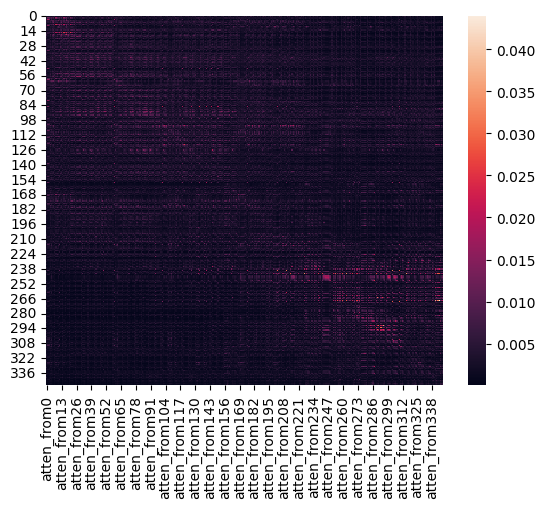

SpeckledBand:Roylott, ranking [1]


,predicate,whom,subject,why,what,where
0,word.predicate:exist,AllTitle:Holmes,SpeckledBand:snake,SpeckledBand:bed,SpeckledBand:bed,SpeckledBand:bed
1,word.predicate:kill,SpeckledBand:Roylott,SpeckledBand:Roylott,SilverBlaze:Colonel_Ross,SpeckledBand:safe,SpeckledBand:Julia_s_bedroom
2,word.predicate:have,SpeckledBand:Helen,AllTitle:Holmes,SpeckledBand:mansion_of_Roylott,SilverBlaze:Colonel_Ross,SpeckledBand:mansion_of_Roylott
3,word.predicate:hit,SpeckledBand:snake,SpeckledBand:Helen,SpeckledBand:Julia_s_bedroom,SpeckledBand:Roylott,SpeckledBand:Roylott
4,word.predicate:sit,SpeckledBand:Julia,bos_e,ResidentPatient:Helper_boy,SpeckledBand:VentilationHole,SilverBlaze:Colonel_Ross
5,word.predicate:die,AllTitle:Watson,word.predicate:hear,SpeckledBand:snake,SpeckledBand:mansion_of_Roylott,AllTitle:Holmes
6,word.predicate:say,SpeckledBand:VentilationHole,SpeckledBand:bed,DateTime:1883-04-01T15:00:00,SpeckledBand:snake,ResidentPatient:Helper_boy
7,word.predicate:open,DancingMen:Cubitt,SilverBlaze:Colonel_Ross,SpeckledBand:Roylott,SpeckledBand:1883-04-01T15,AllTitle:Watson
8,word.predicate:notHear,SpeckledBand:1883-04-01T15,AllTitle:Watson,SpeckledBand:VentilationHole,AllTitle:Holmes,SpeckledBand:VentilationHole
9,word.predicate:marry,SpeckledBand:bed,CrookedMan:Barclay,SpeckledBand:Julia,DateTime:1883-04-01T15:00:00,SpeckledBand:house_of_Holmes


0

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from0
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007166
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006893
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.006591
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.006185
83,bos_e,bos_r,bos_e,0.005881
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005847
149,bos_e,bos_r,bos_e,0.005687
100,bos_e,bos_r,bos_e,0.005626
36,bos_e,bos_r,bos_e,0.005585
42,bos_e,bos_r,bos_e,0.005526


----------


1

['SpeckledBand:341', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from1
3,SpeckledBand:341,kgc:hasPredicate,word.predicate:go,0.018699
60,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.015928
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.015292
9,SpeckledBand:343,kgc:hasPredicate,word.predicate:exist,0.014903
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.014615
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.014162
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.012479
108,SpeckledBand:360,kgc:hasPredicate,word.predicate:approach,0.011804
32,SpeckledBand:347,kgc:hasPredicate,word.predicate:sit,0.011063
114,SpeckledBand:361,kgc:hasPredicate,word.predicate:see,0.010584


----------


2

['SpeckledBand:341', 'kgc:subject', 'AllTitle:Watson']

,head,relation,tail,atten_from2
60,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.011959
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.011533
3,SpeckledBand:341,kgc:hasPredicate,word.predicate:go,0.011375
59,SpeckledBand:352,kgc:subject,AllTitle:Holmes,0.009549
114,SpeckledBand:361,kgc:hasPredicate,word.predicate:see,0.008394
2,SpeckledBand:341,kgc:subject,AllTitle:Watson,0.008344
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.008276
108,SpeckledBand:360,kgc:hasPredicate,word.predicate:approach,0.008076
176,SpeckledBand:371,kgc:subject,AllTitle:Holmes,0.008047
9,SpeckledBand:343,kgc:hasPredicate,word.predicate:exist,0.007937


----------


3

['SpeckledBand:341', 'kgc:hasPredicate', 'word.predicate:go']

,head,relation,tail,atten_from3
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009565
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009342
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008595
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008100
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.008094
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.007773
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.007303
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.006900
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.006840
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.006766


----------


4

['SpeckledBand:341', 'kgc:to', 'SpeckledBand:Roylott_s_bedroom']

,head,relation,tail,atten_from4
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.010547
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.009604
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.009020
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.008077
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.008061
59,SpeckledBand:352,kgc:subject,AllTitle:Holmes,0.007852
2,SpeckledBand:341,kgc:subject,AllTitle:Watson,0.007811
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.007618
309,SpeckledBand:396,kgc:subject,AllTitle:Holmes,0.007435
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006593


----------


5

['SpeckledBand:341', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from5
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.010593
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.009518
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009448
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009202
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.009006
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.008679
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.008459
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008311
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.007815
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.007684


----------


6

['SpeckledBand:341', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from6
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.013584
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.013041
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.012567
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.012296
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.011759
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011353
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010013
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.009640
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.009600
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.009499


----------


7

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from7
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006720
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006553
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.006335
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.006136
83,bos_e,bos_r,bos_e,0.006003
149,bos_e,bos_r,bos_e,0.005782
36,bos_e,bos_r,bos_e,0.005733
100,bos_e,bos_r,bos_e,0.005719
42,bos_e,bos_r,bos_e,0.005667
118,bos_e,bos_r,bos_e,0.005551


----------


8

['SpeckledBand:343', 'kgc:subject', 'SpeckledBand:lanthanum']

,head,relation,tail,atten_from8
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.022744
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.019812
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.016930
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.014778
59,SpeckledBand:352,kgc:subject,AllTitle:Holmes,0.012523
2,SpeckledBand:341,kgc:subject,AllTitle:Watson,0.011964
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.008767
67,SpeckledBand:353,kgc:subject,SpeckledBand:jaw_of_Roylott,0.008658
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.008592
31,SpeckledBand:347,kgc:subject,SpeckledBand:Roylott,0.008535


----------


9

['SpeckledBand:343', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from9
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.013713
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.013619
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.011841
21,SpeckledBand:345,kgc:subject,SpeckledBand:safe,0.011049
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.010213
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.010065
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.009607
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009411
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.008900
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008645


----------


10

['SpeckledBand:343', 'kgc:where', 'SpeckledBand:Roylott_s_bedroom']

,head,relation,tail,atten_from10
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.013281
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.012967
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.011463
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.011115
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.010819
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.008767
67,SpeckledBand:353,kgc:subject,SpeckledBand:jaw_of_Roylott,0.008714
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.008379
11,SpeckledBand:343,kgc:on,SpeckledBand:desk,0.008176
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.008138


----------


11

['SpeckledBand:343', 'kgc:on', 'SpeckledBand:desk']

,head,relation,tail,atten_from11
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.019717
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.015866
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.011782
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.010519
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.010342
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.010261
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010114
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.010030
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.009977
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.009780


----------


12

['SpeckledBand:343', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from12
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.012485
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.012268
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010180
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009841
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009841
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.009782
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009614
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.009423
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.009089
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.009066


----------


13

['SpeckledBand:343', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from13
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.018166
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.015965
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.015270
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.011752
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010850
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.010579
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.009614
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.009292
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.009225
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.009060


----------


14

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from14
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.007251
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007231
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006669
83,bos_e,bos_r,bos_e,0.006017
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.005867
149,bos_e,bos_r,bos_e,0.005807
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005744
36,bos_e,bos_r,bos_e,0.005735
100,bos_e,bos_r,bos_e,0.005734
42,bos_e,bos_r,bos_e,0.005667


----------


15

['SpeckledBand:344', 'kgc:subject', 'SpeckledBand:lanthanum']

,head,relation,tail,atten_from15
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.024553
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.019641
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.016106
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.011788
59,SpeckledBand:352,kgc:subject,AllTitle:Holmes,0.011270
2,SpeckledBand:341,kgc:subject,AllTitle:Watson,0.010477
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.009085
21,SpeckledBand:345,kgc:subject,SpeckledBand:safe,0.008933
31,SpeckledBand:347,kgc:subject,SpeckledBand:Roylott,0.008504
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.008446


----------


16

['SpeckledBand:344', 'kgc:hasPredicate', 'word.predicate:open']

,head,relation,tail,atten_from16
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.013817
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.012176
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010949
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.010246
21,SpeckledBand:345,kgc:subject,SpeckledBand:safe,0.008576
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.008406
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008383
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.008369
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.008308
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.008248


----------


17

['SpeckledBand:344', 'kgc:what', 'SpeckledBand:window']

,head,relation,tail,atten_from17
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.023329
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.023001
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.013419
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.013200
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.013044
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.013038
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.011862
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009949
21,SpeckledBand:345,kgc:subject,SpeckledBand:safe,0.009789
31,SpeckledBand:347,kgc:subject,SpeckledBand:Roylott,0.009575


----------


18

['SpeckledBand:344', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from18
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010905
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.010545
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010043
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.009366
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009270
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.008658
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.008524
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.008505
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008461
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.008437


----------


19

['SpeckledBand:344', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from19
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.013021
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.012950
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.012078
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.010798
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010763
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.010014
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.009735
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.009091
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.009091
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008182


----------


20

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from20
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007717
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007004
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.006649
83,bos_e,bos_r,bos_e,0.005909
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005757
149,bos_e,bos_r,bos_e,0.005672
36,bos_e,bos_r,bos_e,0.005656
100,bos_e,bos_r,bos_e,0.005588
42,bos_e,bos_r,bos_e,0.005586
77,bos_e,bos_r,bos_e,0.005463


----------


21

['SpeckledBand:345', 'kgc:subject', 'SpeckledBand:safe']

,head,relation,tail,atten_from21
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.025377
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.019708
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.012985
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.012362
59,SpeckledBand:352,kgc:subject,AllTitle:Holmes,0.010532
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.009882
21,SpeckledBand:345,kgc:subject,SpeckledBand:safe,0.009740
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.009247
2,SpeckledBand:341,kgc:subject,AllTitle:Watson,0.008693
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.008141


----------


22

['SpeckledBand:345', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from22
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.014418
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.011911
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.011746
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.011126
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.011070
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010596
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.010577
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.010384
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.010233
21,SpeckledBand:345,kgc:subject,SpeckledBand:safe,0.010169


----------


23

['SpeckledBand:345', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from23
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.015027
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.011667
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010451
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010043
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009527
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.009397
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.009043
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.008699
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.008630
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008508


----------


24

['SpeckledBand:345', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from24
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.013277
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.012422
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.011378
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.011111
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.010019
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.009990
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.009988
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.009639
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009431
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.009214


----------


25

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from25
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008133
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007318
83,bos_e,bos_r,bos_e,0.005992
149,bos_e,bos_r,bos_e,0.005786
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005727
36,bos_e,bos_r,bos_e,0.005680
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005675
100,bos_e,bos_r,bos_e,0.005625
42,bos_e,bos_r,bos_e,0.005607
77,bos_e,bos_r,bos_e,0.005529


----------


26

['SpeckledBand:346', 'kgc:subject', 'SpeckledBand:door_of_safe']

,head,relation,tail,atten_from26
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.014635
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.012492
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.010932
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.010919
24,SpeckledBand:345,kgc:time,DateTime:1883-04-02T04:00:00,0.010551
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009237
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.009220
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009043
29,SpeckledBand:346,kgc:time,DateTime:1883-04-02T04:00:00,0.009023
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.008853


----------


27

['SpeckledBand:346', 'kgc:hasProperty', 'word.predicate:open']

,head,relation,tail,atten_from27
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.016915
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.015399
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.014030
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011513
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.011123
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.010180
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010107
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009988
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009943
29,SpeckledBand:346,kgc:time,DateTime:1883-04-02T04:00:00,0.009695


----------


28

['SpeckledBand:346', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from28
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.014918
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.014035
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.013978
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.012959
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.011397
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.011096
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.010941
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010388
29,SpeckledBand:346,kgc:time,DateTime:1883-04-02T04:00:00,0.010166
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.010094


----------


29

['SpeckledBand:346', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from29
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.016308
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.012625
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.011269
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.011199
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.011147
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.010307
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010228
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.010223
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010076
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009941


----------


30

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from30
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007941
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007748
83,bos_e,bos_r,bos_e,0.005892
149,bos_e,bos_r,bos_e,0.005730
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005673
36,bos_e,bos_r,bos_e,0.005636
100,bos_e,bos_r,bos_e,0.005576
42,bos_e,bos_r,bos_e,0.005562
77,bos_e,bos_r,bos_e,0.005465
118,bos_e,bos_r,bos_e,0.005442


----------


31

['SpeckledBand:347', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from31
78,SpeckledBand:355,kgc:subject,SpeckledBand:Roylott,0.010038
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.009887
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.009634
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008939
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.008828
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.008654
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.008583
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.008547
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008427
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.008421


----------


32

['SpeckledBand:347', 'kgc:hasPredicate', 'word.predicate:sit']

,head,relation,tail,atten_from32
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.013825
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.013498
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.013088
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.013002
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.011223
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.011159
21,SpeckledBand:345,kgc:subject,SpeckledBand:safe,0.010583
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.009442
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.009397
194,SpeckledBand:374,kgc:hasProperty,word.predicate:fixed,0.008809


----------


33

['SpeckledBand:347', 'kgc:where', 'SpeckledBand:chair']

,head,relation,tail,atten_from33
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.011093
67,SpeckledBand:353,kgc:subject,SpeckledBand:jaw_of_Roylott,0.008356
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.008192
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.007945
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007769
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.007681
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.007148
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007051
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.006891
162,SpeckledBand:369,kgc:subject,SpeckledBand:Julia,0.006856


----------


34

['SpeckledBand:347', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from34
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.015632
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.011268
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010920
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010764
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.009296
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.009009
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.008953
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008826
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.008750
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.008618


----------


35

['SpeckledBand:347', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from35
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.016054
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.012671
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.011572
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.011356
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.011127
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.011070
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010680
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.010385
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.010221
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.010141


----------


36

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from36
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008285
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007779
83,bos_e,bos_r,bos_e,0.005876
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005759
149,bos_e,bos_r,bos_e,0.005710
100,bos_e,bos_r,bos_e,0.005602
36,bos_e,bos_r,bos_e,0.005591
42,bos_e,bos_r,bos_e,0.005538
118,bos_e,bos_r,bos_e,0.005462
77,bos_e,bos_r,bos_e,0.005430


----------


37

['SpeckledBand:348', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from37
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.008486
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.008070
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007726
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.007721
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.007585
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007581
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.007444
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.007405
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.007222
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007136


----------


38

['SpeckledBand:348', 'kgc:hasProperty', 'word.predicate:wear']

,head,relation,tail,atten_from38
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.012790
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.012647
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010961
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.010701
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.010490
44,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.009949
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009873
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.009805
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.009762
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009384


----------


39

['SpeckledBand:348', 'kgc:what', 'SpeckledBand:decorative_wear']

,head,relation,tail,atten_from39
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.011298
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011087
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010917
127,SpeckledBand:363,kgc:infoSource,AllTitle:Holmes,0.010885
134,SpeckledBand:364,kgc:infoSource,AllTitle:Holmes,0.010829
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.010685
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.010432
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.010277
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010271
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.010172


----------


40

['SpeckledBand:348', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from40
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.012552
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.012250
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.011660
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.011462
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.010540
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.010322
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009136
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.008670
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.008663
29,SpeckledBand:346,kgc:time,DateTime:1883-04-02T04:00:00,0.008646


----------


41

['SpeckledBand:348', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from41
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.013744
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.011438
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010372
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.010350
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010003
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009586
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009570
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.009408
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.009244
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009130


----------


42

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from42
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008371
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007586
83,bos_e,bos_r,bos_e,0.005866
149,bos_e,bos_r,bos_e,0.005696
100,bos_e,bos_r,bos_e,0.005620
36,bos_e,bos_r,bos_e,0.005559
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005541
42,bos_e,bos_r,bos_e,0.005524
118,bos_e,bos_r,bos_e,0.005453
77,bos_e,bos_r,bos_e,0.005390


----------


43

['SpeckledBand:349', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from43
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.009929
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.009647
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.009508
78,SpeckledBand:355,kgc:subject,SpeckledBand:Roylott,0.009410
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008925
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.008809
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.008105
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.007569
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.007467
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007430


----------


44

['SpeckledBand:349', 'kgc:hasProperty', 'word.predicate:wear']

,head,relation,tail,atten_from44
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.013094
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.012208
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010731
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.010565
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010397
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.009378
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009328
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008969
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.008902
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008424


----------


45

['SpeckledBand:349', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from45
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.014807
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.014183
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.013008
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.010215
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.009478
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009266
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.009171
74,SpeckledBand:354,kgc:what,SpeckledBand:eye,0.009119
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009001
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.008736


----------


46

['SpeckledBand:349', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from46
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.011207
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.010927
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010095
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009632
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008761
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008456
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008293
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008176
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008160
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.008129


----------


47

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from47
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008283
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007461
83,bos_e,bos_r,bos_e,0.005845
149,bos_e,bos_r,bos_e,0.005644
36,bos_e,bos_r,bos_e,0.005582
100,bos_e,bos_r,bos_e,0.005549
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005523
42,bos_e,bos_r,bos_e,0.005521
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005418
77,bos_e,bos_r,bos_e,0.005404


----------


48

['SpeckledBand:350', 'kgc:subject', 'SpeckledBand:dog_whip']

,head,relation,tail,atten_from48
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.011562
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011171
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.010878
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.008864
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.008830
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.007708
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.007602
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.007492
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.007471
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.007331


----------


49

['SpeckledBand:350', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from49
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.012009
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.011620
197,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.011606
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.011164
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.010946
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010359
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.009261
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009010
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.008912
191,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.008613


----------


50

['SpeckledBand:350', 'kgc:on', 'SpeckledBand:knee_of_Roylott']

,head,relation,tail,atten_from50
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.015371
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.011170
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010557
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.009918
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.009714
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.008790
125,SpeckledBand:363,kgc:subject,SpeckledBand:snake,0.008745
78,SpeckledBand:355,kgc:subject,SpeckledBand:Roylott,0.008649
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.008587
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.007547


----------


51

['SpeckledBand:350', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from51
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.016087
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.011824
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010718
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009762
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009714
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.008870
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.008768
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.008548
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.008511
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008362


----------


52

['SpeckledBand:350', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from52
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.012403
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.011142
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.010534
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010199
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009874
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009856
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.009789
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009458
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009332
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.009115


----------


53

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from53
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007949
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007475
83,bos_e,bos_r,bos_e,0.005795
149,bos_e,bos_r,bos_e,0.005595
36,bos_e,bos_r,bos_e,0.005530
100,bos_e,bos_r,bos_e,0.005503
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005474
42,bos_e,bos_r,bos_e,0.005455
77,bos_e,bos_r,bos_e,0.005371
118,bos_e,bos_r,bos_e,0.005348


----------


54

['SpeckledBand:351', 'kgc:subject', 'SpeckledBand:dog_whip']

,head,relation,tail,atten_from54
15,SpeckledBand:344,kgc:subject,SpeckledBand:lanthanum,0.012100
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.008915
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.008795
67,SpeckledBand:353,kgc:subject,SpeckledBand:jaw_of_Roylott,0.008766
1,SpeckledBand:341,kgc:subject,AllTitle:Holmes,0.007785
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.007685
59,SpeckledBand:352,kgc:subject,AllTitle:Holmes,0.007624
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007426
31,SpeckledBand:347,kgc:subject,SpeckledBand:Roylott,0.007405
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.007396


----------


55

['SpeckledBand:351', 'kgc:hasProperty', 'word.predicate:strapped']

,head,relation,tail,atten_from55
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010786
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.010479
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.010405
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009835
19,SpeckledBand:344,kgc:time,DateTime:1883-04-02T04:00:00,0.009286
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009275
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.009148
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009033
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008848
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.008560


----------


56

['SpeckledBand:351', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from56
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.011649
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.011518
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010651
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010317
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.010044
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.009679
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.009017
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.008594
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.008441
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.008340


----------


57

['SpeckledBand:351', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from57
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.012522
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.010603
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010071
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.009779
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009683
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009667
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.009509
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.009477
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009277
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.009166


----------


58

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from58
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007825
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007803
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005794
83,bos_e,bos_r,bos_e,0.005626
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005518
149,bos_e,bos_r,bos_e,0.005498
23,SpeckledBand:345,kgc:when,SpeckledBand:1883-04-02T04,0.005479
100,bos_e,bos_r,bos_e,0.005400
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005380
36,bos_e,bos_r,bos_e,0.005370


----------


59

['SpeckledBand:352', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from59
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.019315
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.017103
3,SpeckledBand:341,kgc:hasPredicate,word.predicate:go,0.017085
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.016394
60,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.015105
9,SpeckledBand:343,kgc:hasPredicate,word.predicate:exist,0.014856
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.014505
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.014216
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.014036
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.013800


----------


60

['SpeckledBand:352', 'kgc:hasPredicate', 'word.predicate:see']

,head,relation,tail,atten_from60
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008667
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.008442
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008223
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.008088
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.007984
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007524
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007358
119,SpeckledBand:362,kgc:subject,AllTitle:Holmes,0.006931
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.006908
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.006772


----------


61

['SpeckledBand:352', 'kgc:what', 'SpeckledBand:dog_whip']

,head,relation,tail,atten_from61
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.011143
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.010899
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009537
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008886
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.008806
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008142
152,SpeckledBand:367,kgc:what,SpeckledBand:snake,0.008136
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.007681
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007595
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006929


----------


62

['SpeckledBand:352', 'kgc:where', 'SpeckledBand:Roylott_s_bedroom']

,head,relation,tail,atten_from62
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.010440
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.008326
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007675
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007511
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007259
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007147
304,SpeckledBand:395,kgc:hasPredicate,word.predicate:hear,0.006896
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.006896
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.006746
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.006447


----------


63

['SpeckledBand:352', 'kgc:when', 'SpeckledBand:daytime']

,head,relation,tail,atten_from63
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.009522
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008776
74,SpeckledBand:354,kgc:what,SpeckledBand:eye,0.008290
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.007937
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.007847
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007563
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.006980
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.006628
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.006524
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.006488


----------


64

['SpeckledBand:352', 'kgc:when', 'SpeckledBand:1883-04-01T14']

,head,relation,tail,atten_from64
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.012747
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009191
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009114
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009047
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008649
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008640
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008550
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.008310
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.007833
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.007384


----------


65

['SpeckledBand:352', 'kgc:time', 'DateTime:1883-04-01T14:00:00']

,head,relation,tail,atten_from65
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.013245
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.011875
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.011104
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010597
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.010466
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.010220
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009769
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.009728
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009564
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.009460


----------


66

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from66
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007933
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007412
83,bos_e,bos_r,bos_e,0.005690
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005685
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005587
149,bos_e,bos_r,bos_e,0.005512
23,SpeckledBand:345,kgc:when,SpeckledBand:1883-04-02T04,0.005492
100,bos_e,bos_r,bos_e,0.005459
36,bos_e,bos_r,bos_e,0.005442
42,bos_e,bos_r,bos_e,0.005364


----------


67

['SpeckledBand:353', 'kgc:subject', 'SpeckledBand:jaw_of_Roylott']

,head,relation,tail,atten_from67
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008002
176,SpeckledBand:371,kgc:subject,AllTitle:Holmes,0.007954
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.007922
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007863
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.007553
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.007322
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007274
59,SpeckledBand:352,kgc:subject,AllTitle:Holmes,0.007071
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.006917
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.006908


----------


68

['SpeckledBand:353', 'kgc:hasPredicate', 'word.predicate:upward']

,head,relation,tail,atten_from68
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009836
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008481
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008239
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008198
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.008143
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008102
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.007846
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.007623
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.007417
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007331


----------


69

['SpeckledBand:353', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from69
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.013373
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.011008
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.010725
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008497
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008368
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.008263
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.007914
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.007910
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.007851
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.007486


----------


70

['SpeckledBand:353', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from70
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.011126
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010717
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010401
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010353
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.009631
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009617
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009395
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009380
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009235
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008733


----------


71

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from71
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007827
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007779
83,bos_e,bos_r,bos_e,0.005837
149,bos_e,bos_r,bos_e,0.005648
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005556
36,bos_e,bos_r,bos_e,0.005553
100,bos_e,bos_r,bos_e,0.005551
42,bos_e,bos_r,bos_e,0.005483
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005444
77,bos_e,bos_r,bos_e,0.005417


----------


72

['SpeckledBand:354', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from72
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008918
78,SpeckledBand:355,kgc:subject,SpeckledBand:Roylott,0.008873
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.008363
101,SpeckledBand:359,kgc:subject,AllTitle:Holmes,0.008156
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008083
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007842
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.006907
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.006734
31,SpeckledBand:347,kgc:subject,SpeckledBand:Roylott,0.006619
176,SpeckledBand:371,kgc:subject,AllTitle:Holmes,0.006594


----------


73

['SpeckledBand:354', 'kgc:hasPredicate', 'word.predicate:open']

,head,relation,tail,atten_from73
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.015948
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.014464
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.012826
54,SpeckledBand:351,kgc:subject,SpeckledBand:dog_whip,0.009918
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.009783
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009642
91,SpeckledBand:357,kgc:hasProperty,word.predicate:brown_specled_yellow_band,0.009437
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.009345
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009342
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.008804


----------


74

['SpeckledBand:354', 'kgc:what', 'SpeckledBand:eye']

,head,relation,tail,atten_from74
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.012218
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009459
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009273
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009156
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.008996
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.008955
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008920
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.008851
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008823
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.008738


----------


75

['SpeckledBand:354', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from75
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.016278
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.013438
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.012097
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.010524
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.009852
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009659
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009132
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.009047
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008961
35,SpeckledBand:347,kgc:time,DateTime:1883-04-02T04:00:00,0.008227


----------


76

['SpeckledBand:354', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from76
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011568
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.011248
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.011048
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010506
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010430
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.010290
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009885
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.009862
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.009004
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008408


----------


77

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from77
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007819
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007772
83,bos_e,bos_r,bos_e,0.005807
149,bos_e,bos_r,bos_e,0.005613
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005571
100,bos_e,bos_r,bos_e,0.005540
36,bos_e,bos_r,bos_e,0.005496
42,bos_e,bos_r,bos_e,0.005448
118,bos_e,bos_r,bos_e,0.005391
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005373


----------


78

['SpeckledBand:355', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from78
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007956
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.007753
101,SpeckledBand:359,kgc:subject,AllTitle:Holmes,0.007729
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.007283
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.007021
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.006992
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.006955
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.006737
147,SpeckledBand:366,kgc:when,SpeckledBand:1883-04-02T04,0.006617
110,SpeckledBand:360,kgc:when,SpeckledBand:1883-04-02T04,0.006544


----------


79

['SpeckledBand:355', 'kgc:hasPredicate', 'word.predicate:see']

,head,relation,tail,atten_from79
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.012919
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008781
194,SpeckledBand:374,kgc:hasProperty,word.predicate:fixed,0.008773
179,SpeckledBand:371,kgc:when,SpeckledBand:1883-04-01T15,0.008740
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008338
147,SpeckledBand:366,kgc:when,SpeckledBand:1883-04-02T04,0.008185
91,SpeckledBand:357,kgc:hasProperty,word.predicate:brown_specled_yellow_band,0.007669
211,SpeckledBand:376,kgc:when,SpeckledBand:1883-04-01T15,0.007190
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.007029
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.006931


----------


80

['SpeckledBand:355', 'kgc:what', 'SpeckledBand:corner_of_ceiling']

,head,relation,tail,atten_from80
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.013776
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.011850
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.011285
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010532
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.010325
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010228
134,SpeckledBand:364,kgc:infoSource,AllTitle:Holmes,0.009272
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008798
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008674
127,SpeckledBand:363,kgc:infoSource,AllTitle:Holmes,0.008574


----------


81

['SpeckledBand:355', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from81
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.012325
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.011359
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.011070
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010777
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010470
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.010065
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008973
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008926
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.007774
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007697


----------


82

['SpeckledBand:355', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from82
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.011725
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.011077
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010440
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009570
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009498
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.009298
57,SpeckledBand:351,kgc:time,DateTime:1883-04-02T04:00:00,0.009225
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009224
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009152
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.008915


----------


83

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from83
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007723
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007580
83,bos_e,bos_r,bos_e,0.005758
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005592
149,bos_e,bos_r,bos_e,0.005574
92,SpeckledBand:357,kgc:when,SpeckledBand:1883-04-02T04,0.005514
100,bos_e,bos_r,bos_e,0.005511
36,bos_e,bos_r,bos_e,0.005389
42,bos_e,bos_r,bos_e,0.005361
118,bos_e,bos_r,bos_e,0.005341


----------


84

['SpeckledBand:356', 'kgc:subject', 'SpeckledBand:band']

,head,relation,tail,atten_from84
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.010142
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.010001
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.009772
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.009316
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009131
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008691
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008646
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.008564
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.007958
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.007670


----------


85

['SpeckledBand:356', 'kgc:hasPredicate', 'word.predicate:squeeze']

,head,relation,tail,atten_from85
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.014884
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011934
91,SpeckledBand:357,kgc:hasProperty,word.predicate:brown_specled_yellow_band,0.011557
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.009590
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009120
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008933
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008922
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.008634
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008546
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.008038


----------


86

['SpeckledBand:356', 'kgc:what', 'SpeckledBand:neck_of_Roylott']

,head,relation,tail,atten_from86
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.013927
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.011434
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.011159
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.011018
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.010881
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.010668
91,SpeckledBand:357,kgc:hasProperty,word.predicate:brown_specled_yellow_band,0.010586
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.010484
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010470
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.009818


----------


87

['SpeckledBand:356', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from87
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.016221
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.013174
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.013159
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.011673
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.011494
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.010912
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.009763
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009014
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008819
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.008079


----------


88

['SpeckledBand:356', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from88
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.014143
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.011999
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.010394
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009878
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.009280
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009255
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008938
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008522
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008458
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.008347


----------


89

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from89
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007729
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007415
83,bos_e,bos_r,bos_e,0.005894
149,bos_e,bos_r,bos_e,0.005637
100,bos_e,bos_r,bos_e,0.005603
36,bos_e,bos_r,bos_e,0.005548
42,bos_e,bos_r,bos_e,0.005528
118,bos_e,bos_r,bos_e,0.005411
77,bos_e,bos_r,bos_e,0.005411
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005326


----------


90

['SpeckledBand:357', 'kgc:subject', 'SpeckledBand:band']

,head,relation,tail,atten_from90
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011346
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.010467
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009202
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.008677
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008525
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008385
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.008151
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.007840
127,SpeckledBand:363,kgc:infoSource,AllTitle:Holmes,0.007669
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.007590


----------


91

['SpeckledBand:357',
 'kgc:hasProperty',
 'word.predicate:brown_specled_yellow_band']

,head,relation,tail,atten_from91
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.015799
91,SpeckledBand:357,kgc:hasProperty,word.predicate:brown_specled_yellow_band,0.013108
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.012282
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.010447
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010054
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.009772
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009665
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.009245
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.009055
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008809


----------


92

['SpeckledBand:357', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from92
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.016056
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009796
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009048
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009012
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008876
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.008736
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.007833
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.007661
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007333
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.007087


----------


93

['SpeckledBand:357', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from93
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010994
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.010002
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009848
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008993
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008557
147,SpeckledBand:366,kgc:when,SpeckledBand:1883-04-02T04,0.008282
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008227
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.008205
116,SpeckledBand:361,kgc:when,SpeckledBand:1883-04-02T04,0.007944
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.007859


----------


94

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from94
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007849
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007385
83,bos_e,bos_r,bos_e,0.005821
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005791
149,bos_e,bos_r,bos_e,0.005579
100,bos_e,bos_r,bos_e,0.005563
36,bos_e,bos_r,bos_e,0.005505
42,bos_e,bos_r,bos_e,0.005488
118,bos_e,bos_r,bos_e,0.005402
77,bos_e,bos_r,bos_e,0.005360


----------


95

['SpeckledBand:358', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from95
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.014428
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.013794
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.012509
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011231
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.010206
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.009829
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.009132
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008976
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.008659
101,SpeckledBand:359,kgc:subject,AllTitle:Holmes,0.008454


----------


96

['SpeckledBand:358', 'kgc:hasPredicate', 'word.predicate:dead']

,head,relation,tail,atten_from96
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011991
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011139
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.010661
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.009930
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009439
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.008705
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.008653
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008283
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007856
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.007446


----------


97

['SpeckledBand:358', 'kgc:when', 'SpeckledBand:341']

,head,relation,tail,atten_from97
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011805
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.011099
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008239
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008091
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.007994
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.007916
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.007871
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.007852
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.007520
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.007400


----------


98

['SpeckledBand:358', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from98
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011196
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008640
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008347
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008281
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008116
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008046
82,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.007641
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.007332
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.006928
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.006749


----------


99

['SpeckledBand:358', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from99
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.014639
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.011953
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.010753
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.010272
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.010020
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009736
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009717
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008725
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.008078
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007899


----------


100

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from100
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007913
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006929
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005925
83,bos_e,bos_r,bos_e,0.005807
149,bos_e,bos_r,bos_e,0.005610
100,bos_e,bos_r,bos_e,0.005572
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005516
118,bos_e,bos_r,bos_e,0.005413
36,bos_e,bos_r,bos_e,0.005403
42,bos_e,bos_r,bos_e,0.005380


----------


101

['SpeckledBand:359', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from101
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.021935
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.018539
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.017585
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.014752
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.014073
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.012302
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.011305
9,SpeckledBand:343,kgc:hasPredicate,word.predicate:exist,0.011262
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.010522
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.009841


----------


102

['SpeckledBand:359', 'kgc:hasPredicate', 'word.predicate:say']

,head,relation,tail,atten_from102
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.014617
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012652
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.011977
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010295
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.010148
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008622
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.008172
122,SpeckledBand:362,kgc:when,SpeckledBand:1883-04-02T04,0.007988
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.007951
147,SpeckledBand:366,kgc:when,SpeckledBand:1883-04-02T04,0.007547


----------


103

['SpeckledBand:359', 'kgc:what', 'SpeckledBand:speckled_band']

,head,relation,tail,atten_from103
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.019799
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.019107
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.013600
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.012879
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.012659
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.011047
134,SpeckledBand:364,kgc:infoSource,AllTitle:Holmes,0.010393
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.010391
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.009140
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.009089


----------


104

['SpeckledBand:359', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from104
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010137
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.010120
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.009474
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009044
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008279
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008071
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008016
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.007866
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.007676
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007670


----------


105

['SpeckledBand:359', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from105
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.015193
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.011669
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.011268
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.011206
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010316
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.010126
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008893
116,SpeckledBand:361,kgc:when,SpeckledBand:1883-04-02T04,0.008419
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008381
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007813


----------


106

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from106
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007798
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006112
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.006110
83,bos_e,bos_r,bos_e,0.005892
149,bos_e,bos_r,bos_e,0.005660
100,bos_e,bos_r,bos_e,0.005631
64,SpeckledBand:352,kgc:when,SpeckledBand:1883-04-01T14,0.005470
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005466
118,bos_e,bos_r,bos_e,0.005465
36,bos_e,bos_r,bos_e,0.005462


----------


107

['SpeckledBand:360', 'kgc:subject', 'AllTitle:Watson']

,head,relation,tail,atten_from107
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.010039
177,SpeckledBand:371,kgc:hasPredicate,word.predicate:focus,0.009617
108,SpeckledBand:360,kgc:hasPredicate,word.predicate:approach,0.009489
114,SpeckledBand:361,kgc:hasPredicate,word.predicate:see,0.009310
60,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.008659
310,SpeckledBand:396,kgc:hasPredicate,word.predicate:hit,0.008282
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008100
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.007905
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.007651
102,SpeckledBand:359,kgc:hasPredicate,word.predicate:say,0.007578


----------


108

['SpeckledBand:360', 'kgc:hasPredicate', 'word.predicate:approach']

,head,relation,tail,atten_from108
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010601
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009829
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.009445
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008459
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.007167
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007106
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.006982
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.006960
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.006864
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.006721


----------


109

['SpeckledBand:360', 'kgc:to', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from109
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.010036
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009258
309,SpeckledBand:396,kgc:subject,AllTitle:Holmes,0.008145
108,SpeckledBand:360,kgc:hasPredicate,word.predicate:approach,0.008122
107,SpeckledBand:360,kgc:subject,AllTitle:Watson,0.007499
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.007074
303,SpeckledBand:395,kgc:subject,AllTitle:Holmes,0.007073
176,SpeckledBand:371,kgc:subject,AllTitle:Holmes,0.006803
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.006475
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.006446


----------


110

['SpeckledBand:360', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from110
74,SpeckledBand:354,kgc:what,SpeckledBand:eye,0.008329
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008182
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007379
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007375
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.007122
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.006890
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.006880
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.006506
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.006497
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.006205


----------


111

['SpeckledBand:360', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from111
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.013804
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.011286
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.010154
110,SpeckledBand:360,kgc:when,SpeckledBand:1883-04-02T04,0.009375
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008490
116,SpeckledBand:361,kgc:when,SpeckledBand:1883-04-02T04,0.008023
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.007834
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.007804
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007697
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.007503


----------


112

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from112
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007955
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006716
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.006032
83,bos_e,bos_r,bos_e,0.005901
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005701
149,bos_e,bos_r,bos_e,0.005641
100,bos_e,bos_r,bos_e,0.005606
23,SpeckledBand:345,kgc:when,SpeckledBand:1883-04-02T04,0.005532
36,bos_e,bos_r,bos_e,0.005519
42,bos_e,bos_r,bos_e,0.005482


----------


113

['SpeckledBand:361', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from113
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.010515
176,SpeckledBand:371,kgc:subject,AllTitle:Holmes,0.010105
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009356
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.008268
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.008176
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.007484
107,SpeckledBand:360,kgc:subject,AllTitle:Watson,0.007292
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.007245
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.007041
119,SpeckledBand:362,kgc:subject,AllTitle:Holmes,0.007039


----------


114

['SpeckledBand:361', 'kgc:hasPredicate', 'word.predicate:see']

,head,relation,tail,atten_from114
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.012244
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009759
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009574
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009088
162,SpeckledBand:369,kgc:subject,SpeckledBand:Julia,0.008639
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.008258
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007855
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.007452
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.007173
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.007116


----------


115

['SpeckledBand:361', 'kgc:what', 'AllTitle:Watson']

,head,relation,tail,atten_from115
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.009435
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.009346
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008608
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008032
110,SpeckledBand:360,kgc:when,SpeckledBand:1883-04-02T04,0.007866
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.007587
116,SpeckledBand:361,kgc:when,SpeckledBand:1883-04-02T04,0.007535
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.007481
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.007282
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007132


----------


116

['SpeckledBand:361', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from116
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008863
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008178
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007622
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.007594
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.007434
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007356
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.007271
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.007118
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.006960
43,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.006914


----------


117

['SpeckledBand:361', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from117
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.013071
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.012351
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.010601
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010140
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.010030
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009828
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.008947
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008943
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008593
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.008473


----------


118

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from118
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007571
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006930
83,bos_e,bos_r,bos_e,0.005962
149,bos_e,bos_r,bos_e,0.005749
100,bos_e,bos_r,bos_e,0.005656
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005608
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005583
36,bos_e,bos_r,bos_e,0.005526
118,bos_e,bos_r,bos_e,0.005493
42,bos_e,bos_r,bos_e,0.005489


----------


119

['SpeckledBand:362', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from119
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.018689
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.017475
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.012816
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.012181
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.011553
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.011104
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.011037
9,SpeckledBand:343,kgc:hasPredicate,word.predicate:exist,0.010375
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.010052
114,SpeckledBand:361,kgc:hasPredicate,word.predicate:see,0.009622


----------


120

['SpeckledBand:362', 'kgc:hasPredicate', 'word.predicate:say']

,head,relation,tail,atten_from120
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.015152
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.013046
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.011819
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010875
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.009894
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.009797
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008923
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.008912
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.008903
122,SpeckledBand:362,kgc:when,SpeckledBand:1883-04-02T04,0.007155


----------


121

['SpeckledBand:362', 'kgc:what', 'SpeckledBand:poisonous_snake']

,head,relation,tail,atten_from121
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.025206
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.020055
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.015729
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010921
134,SpeckledBand:364,kgc:infoSource,AllTitle:Holmes,0.010595
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.010505
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010484
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009744
115,SpeckledBand:361,kgc:what,AllTitle:Watson,0.009407
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.008988


----------


122

['SpeckledBand:362', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from122
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011435
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010710
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008535
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008420
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008045
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.007436
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.007282
74,SpeckledBand:354,kgc:what,SpeckledBand:eye,0.007252
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.006793
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.006733


----------


123

['SpeckledBand:362', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from123
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.013855
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012470
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010159
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008183
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.008153
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.008029
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.007907
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.007664
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.007622
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007540


----------


124

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from124
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007453
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007429
83,bos_e,bos_r,bos_e,0.006067
149,bos_e,bos_r,bos_e,0.005794
100,bos_e,bos_r,bos_e,0.005756
42,bos_e,bos_r,bos_e,0.005637
36,bos_e,bos_r,bos_e,0.005636
118,bos_e,bos_r,bos_e,0.005566
77,bos_e,bos_r,bos_e,0.005532
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005447


----------


125

['SpeckledBand:363', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from125
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.009405
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008412
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.008219
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.008202
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.008032
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.007870
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.007648
193,SpeckledBand:374,kgc:subject,SpeckledBand:bed,0.007593
125,SpeckledBand:363,kgc:subject,SpeckledBand:snake,0.007390
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.007309


----------


126

['SpeckledBand:363',
 'kgc:hasProperty',
 'word.predicate:the_most_terrible_snake_of_India']

,head,relation,tail,atten_from126
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010410
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.010092
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.009764
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009400
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.009282
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.009218
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009017
125,SpeckledBand:363,kgc:subject,SpeckledBand:snake,0.008401
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008204
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008015


----------


127

['SpeckledBand:363', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from127
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.018993
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.012838
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.011445
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.010704
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.009346
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.008936
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.008632
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.007654
260,SpeckledBand:386,kgc:hasPredicate,word.predicate:callBack,0.007500
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.007300


----------


128

['SpeckledBand:363', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from128
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.014520
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008896
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.008304
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.008149
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007740
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.007635
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.007492
43,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.007327
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.007124
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.006937


----------


129

['SpeckledBand:363', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from129
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010291
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010278
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.009763
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009635
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008951
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.008195
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.008108
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008056
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.007901
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.007314


----------


130

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from130
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007656
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007482
83,bos_e,bos_r,bos_e,0.005975
149,bos_e,bos_r,bos_e,0.005701
100,bos_e,bos_r,bos_e,0.005650
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005644
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005589
36,bos_e,bos_r,bos_e,0.005576
42,bos_e,bos_r,bos_e,0.005570
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005524


----------


131

['SpeckledBand:364', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from131
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.009619
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.009363
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.009321
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.009280
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.009024
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008529
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.008407
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008206
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.008089
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007883


----------


132

['SpeckledBand:364', 'kgc:hasPredicate', 'word.predicate:bite']

,head,relation,tail,atten_from132
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012988
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009930
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008828
43,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.007333
125,SpeckledBand:363,kgc:subject,SpeckledBand:snake,0.007115
162,SpeckledBand:369,kgc:subject,SpeckledBand:Julia,0.007078
131,SpeckledBand:364,kgc:subject,SpeckledBand:snake,0.006880
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.006563
133,SpeckledBand:364,kgc:whom,SpeckledBand:Roylott,0.006438
115,SpeckledBand:361,kgc:what,AllTitle:Watson,0.006433


----------


133

['SpeckledBand:364', 'kgc:whom', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from133
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.018619
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.012321
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.012168
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.011798
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.011046
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010844
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010816
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010212
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.010185
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009799


----------


134

['SpeckledBand:364', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from134
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.023818
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.017217
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.015290
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.014600
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.012338
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.010477
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.009751
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.009504
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.009203
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009189


----------


135

['SpeckledBand:364', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from135
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011355
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008829
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.008498
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007364
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.007274
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.007011
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.006856
43,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.006702
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.006691
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.006675


----------


136

['SpeckledBand:364', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from136
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010630
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009708
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009445
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009232
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008711
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.007635
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.007629
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.007601
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007601
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.007537


----------


137

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from137
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007714
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007305
83,bos_e,bos_r,bos_e,0.005970
149,bos_e,bos_r,bos_e,0.005717
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005618
100,bos_e,bos_r,bos_e,0.005596
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005589
36,bos_e,bos_r,bos_e,0.005588
42,bos_e,bos_r,bos_e,0.005552
77,bos_e,bos_r,bos_e,0.005493


----------


138

['SpeckledBand:365', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from138
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.016282
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.012673
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.012270
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010977
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.009283
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.009176
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.009100
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.008656
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.008636
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.008490


----------


139

['SpeckledBand:365', 'kgc:hasPredicate', 'word.predicate:die']

,head,relation,tail,atten_from139
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.012014
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.011051
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.009637
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.009469
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.009143
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.008748
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.008581
123,SpeckledBand:362,kgc:time,DateTime:1883-04-02T04:00:00,0.008509
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.008500
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008262


----------


140

['SpeckledBand:365', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from140
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.021658
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.018708
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.018417
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.014362
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.010097
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.010042
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.009019
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.008683
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.008635
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.008060


----------


141

['SpeckledBand:365', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from141
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010972
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.008214
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007432
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.007137
43,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.007034
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.006910
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.006872
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.006814
44,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.006734
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.006622


----------


142

['SpeckledBand:365', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from142
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.010085
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.010026
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009893
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009459
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009052
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008651
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.008340
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008105
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.008004
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.007919


----------


143

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from143
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007617
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007320
83,bos_e,bos_r,bos_e,0.005959
149,bos_e,bos_r,bos_e,0.005764
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005594
100,bos_e,bos_r,bos_e,0.005593
36,bos_e,bos_r,bos_e,0.005519
42,bos_e,bos_r,bos_e,0.005475
77,bos_e,bos_r,bos_e,0.005462
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005440


----------


144

['SpeckledBand:366', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from144
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.020290
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.015738
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.012597
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.012004
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.010653
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.009377
9,SpeckledBand:343,kgc:hasPredicate,word.predicate:exist,0.007859
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.007506
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.007488
79,SpeckledBand:355,kgc:hasPredicate,word.predicate:see,0.007458


----------


145

['SpeckledBand:366', 'kgc:hasPredicate', 'word.predicate:have']

,head,relation,tail,atten_from145
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.020235
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.019178
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.013197
91,SpeckledBand:357,kgc:hasProperty,word.predicate:brown_specled_yellow_band,0.011042
44,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.010873
194,SpeckledBand:374,kgc:hasProperty,word.predicate:fixed,0.010485
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010472
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.009728
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.009289
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009120


----------


146

['SpeckledBand:366', 'kgc:what', 'SpeckledBand:dog_whip_of_Roylott']

,head,relation,tail,atten_from146
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.014339
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.014007
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.013008
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.012377
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.011775
134,SpeckledBand:364,kgc:infoSource,AllTitle:Holmes,0.011565
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.010290
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009884
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.009755
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.009441


----------


147

['SpeckledBand:366', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from147
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011108
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009168
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.009094
44,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.007690
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007603
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.007480
70,SpeckledBand:353,kgc:time,DateTime:1883-04-02T04:00:00,0.007452
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.007406
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.007375
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007294


----------


148

['SpeckledBand:366', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from148
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011312
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010230
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009535
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.008407
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008349
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008112
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.007857
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.007793
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.007563
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.007488


----------


149

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from149
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007368
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007137
83,bos_e,bos_r,bos_e,0.006021
149,bos_e,bos_r,bos_e,0.005832
100,bos_e,bos_r,bos_e,0.005661
36,bos_e,bos_r,bos_e,0.005549
42,bos_e,bos_r,bos_e,0.005511
77,bos_e,bos_r,bos_e,0.005496
118,bos_e,bos_r,bos_e,0.005475
143,bos_e,bos_r,bos_e,0.005429


----------


150

['SpeckledBand:367', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from150
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.020104
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.011664
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.011552
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.010905
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.009310
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009196
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.008609
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008098
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.007798
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.007389


----------


151

['SpeckledBand:367', 'kgc:hasPredicate', 'word.predicate:putInto']

,head,relation,tail,atten_from151
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012017
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.011822
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010663
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010173
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.009596
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.009308
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.009260
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008836
123,SpeckledBand:362,kgc:time,DateTime:1883-04-02T04:00:00,0.008526
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.008262


----------


152

['SpeckledBand:367', 'kgc:what', 'SpeckledBand:snake']

,head,relation,tail,atten_from152
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012356
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.012065
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011587
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010143
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.009945
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.009413
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.009100
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.008761
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008727
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.008417


----------


153

['SpeckledBand:367', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from153
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.015428
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.009585
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.008858
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.008390
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.007916
44,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.007794
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.007688
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.007556
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.007495
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007431


----------


154

['SpeckledBand:367', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from154
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011631
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009053
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008914
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008907
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008842
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008357
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.007895
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.007755
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.007590
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.007245


----------


155

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from155
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007560
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007496
83,bos_e,bos_r,bos_e,0.006032
149,bos_e,bos_r,bos_e,0.005831
100,bos_e,bos_r,bos_e,0.005655
36,bos_e,bos_r,bos_e,0.005627
42,bos_e,bos_r,bos_e,0.005581
77,bos_e,bos_r,bos_e,0.005533
118,bos_e,bos_r,bos_e,0.005475
143,bos_e,bos_r,bos_e,0.005441


----------


156

['SpeckledBand:368', 'kgc:subject', 'SpeckledBand:Roma']

,head,relation,tail,atten_from156
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.011098
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.009795
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.008983
162,SpeckledBand:369,kgc:subject,SpeckledBand:Julia,0.008530
101,SpeckledBand:359,kgc:subject,AllTitle:Holmes,0.008521
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008299
197,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.008059
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.008035
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.007933
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.007783


----------


157

['SpeckledBand:368', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from157
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010423
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010182
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.009822
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009787
197,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.009657
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.009146
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.008964
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.008888
191,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.008182
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.007825


----------


158

['SpeckledBand:368', 'kgc:where', 'SpeckledBand:mansion_of_Roylott']

,head,relation,tail,atten_from158
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.009749
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.008968
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.008058
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007863
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.007512
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.007232
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.007041
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.006693
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.006483
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.006456


----------


159

['SpeckledBand:368', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from159
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.012146
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.008052
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.007692
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.007576
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.007478
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.007456
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.007209
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.006479
154,SpeckledBand:367,kgc:time,DateTime:1883-04-02T04:00:00,0.006346
48,SpeckledBand:350,kgc:subject,SpeckledBand:dog_whip,0.006249


----------


160

['SpeckledBand:368', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from160
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.012894
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.012601
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.011564
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.011170
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.011105
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.010722
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.010311
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.010181
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.010070
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.009702


----------


161

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from161
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007268
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007160
83,bos_e,bos_r,bos_e,0.006089
149,bos_e,bos_r,bos_e,0.005912
36,bos_e,bos_r,bos_e,0.005701
100,bos_e,bos_r,bos_e,0.005694
42,bos_e,bos_r,bos_e,0.005632
77,bos_e,bos_r,bos_e,0.005596
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005588
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005556


----------


162

['SpeckledBand:369', 'kgc:subject', 'SpeckledBand:Julia']

,head,relation,tail,atten_from162
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.014363
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013715
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.011107
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.009233
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.007900
78,SpeckledBand:355,kgc:subject,SpeckledBand:Roylott,0.007889
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.007739
162,SpeckledBand:369,kgc:subject,SpeckledBand:Julia,0.007030
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.006603
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.006522


----------


163

['SpeckledBand:369', 'kgc:hasPredicate', 'word.predicate:say']

,head,relation,tail,atten_from163
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.015295
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.015199
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.013163
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.012524
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010473
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.008722
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008530
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.007869
95,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.007732
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.007159


----------


164

['SpeckledBand:369', 'kgc:what', 'SpeckledBand:speckled_band']

,head,relation,tail,atten_from164
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.011783
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.011027
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.009860
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.009513
115,SpeckledBand:361,kgc:what,AllTitle:Watson,0.009422
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.009224
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009115
170,SpeckledBand:370,kgc:to,SpeckledBand:Julia_s_bedroom,0.008421
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.008330
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.008330


----------


165

['SpeckledBand:369', 'kgc:when', 'SpeckledBand:1881-12-02T00']

,head,relation,tail,atten_from165
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.011795
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.007820
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.007107
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.007070
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.006808
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.006755
76,SpeckledBand:354,kgc:time,DateTime:1883-04-02T04:00:00,0.006747
150,SpeckledBand:367,kgc:subject,AllTitle:Holmes,0.006596
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.006456
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.006360


----------


166

['SpeckledBand:369', 'kgc:time', 'DateTime:1881-12-02T00:00:00']

,head,relation,tail,atten_from166
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.013277
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.012287
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.009870
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009848
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009832
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.008387
93,SpeckledBand:357,kgc:time,DateTime:1883-04-02T04:00:00,0.008154
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008071
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008004
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007794


----------


167

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from167
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007394
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006874
83,bos_e,bos_r,bos_e,0.005931
149,bos_e,bos_r,bos_e,0.005770
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005692
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.005677
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005605
100,bos_e,bos_r,bos_e,0.005593
36,bos_e,bos_r,bos_e,0.005582
23,SpeckledBand:345,kgc:when,SpeckledBand:1883-04-02T04,0.005576


----------


168

['SpeckledBand:370', 'kgc:subject', 'SpeckledBand:Danger']

,head,relation,tail,atten_from168
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.015300
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009967
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009220
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.009155
109,SpeckledBand:360,kgc:to,SpeckledBand:Roylott,0.009119
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.008886
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.008546
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.008479
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.007886
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.007583


----------


169

['SpeckledBand:370', 'kgc:hasPredicate', 'word.predicate:notEnter']

,head,relation,tail,atten_from169
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008404
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008212
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.007414
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.007106
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.006930
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.006533
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.006230
8,SpeckledBand:343,kgc:subject,SpeckledBand:lanthanum,0.006105
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.005994
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.005744


----------


170

['SpeckledBand:370', 'kgc:to', 'SpeckledBand:Julia_s_bedroom']

,head,relation,tail,atten_from170
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009983
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.009424
108,SpeckledBand:360,kgc:hasPredicate,word.predicate:approach,0.008676
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008470
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008463
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008401
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.008221
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.008098
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.007707
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.007533


----------


171

['SpeckledBand:370', 'kgc:from', 'SpeckledBand:window_of_Julia_s_bedroom']

,head,relation,tail,atten_from171
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.010491
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.008679
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008353
62,SpeckledBand:352,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007718
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007603
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007545
176,SpeckledBand:371,kgc:subject,AllTitle:Holmes,0.007533
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.007382
309,SpeckledBand:396,kgc:subject,AllTitle:Holmes,0.007317
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.007010


----------


172

['SpeckledBand:370', 'kgc:from', 'SpeckledBand:door_of_Julia_s_bedroom']

,head,relation,tail,atten_from172
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.010839
176,SpeckledBand:371,kgc:subject,AllTitle:Holmes,0.007953
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007512
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.007378
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.007330
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.007285
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.007055
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.006440
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.006434
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.006408


----------


173

['SpeckledBand:370', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from173
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.009607
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008202
113,SpeckledBand:361,kgc:subject,SpeckledBand:snake,0.006858
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.006609
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.006609
109,SpeckledBand:360,kgc:to,SpeckledBand:Roylott,0.006413
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.006115
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.006056
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.005730
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.005621


----------


174

['SpeckledBand:370', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from174
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011521
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.010933
110,SpeckledBand:360,kgc:when,SpeckledBand:1883-04-02T04,0.010587
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.010357
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009901
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.009145
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008596
109,SpeckledBand:360,kgc:to,SpeckledBand:Roylott,0.008493
116,SpeckledBand:361,kgc:when,SpeckledBand:1883-04-02T04,0.008045
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.007916


----------


175

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from175
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007121
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006840
83,bos_e,bos_r,bos_e,0.005955
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005918
149,bos_e,bos_r,bos_e,0.005809
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.005711
100,bos_e,bos_r,bos_e,0.005681
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005655
36,bos_e,bos_r,bos_e,0.005588
42,bos_e,bos_r,bos_e,0.005519


----------


176

['SpeckledBand:371', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from176
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.020847
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.017210
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.013811
260,SpeckledBand:386,kgc:hasPredicate,word.predicate:callBack,0.013623
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.012903
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.012799
96,SpeckledBand:358,kgc:hasPredicate,word.predicate:dead,0.011094
139,SpeckledBand:365,kgc:hasPredicate,word.predicate:die,0.010534
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.009738
151,SpeckledBand:367,kgc:hasPredicate,word.predicate:putInto,0.009635


----------


177

['SpeckledBand:371', 'kgc:hasPredicate', 'word.predicate:focus']

,head,relation,tail,atten_from177
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.015583
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.014778
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010508
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.009552
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.009348
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.009308
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.008158
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008148
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.008070
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.007676


----------


178

['SpeckledBand:371', 'kgc:what', 'SpeckledBand:VentilationHole']

,head,relation,tail,atten_from178
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.013939
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.012592
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.012173
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.011310
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010949
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.009222
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.008492
4,SpeckledBand:341,kgc:to,SpeckledBand:Roylott_s_bedroom,0.007808
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.007055
109,SpeckledBand:360,kgc:to,SpeckledBand:Roylott,0.007005


----------


179

['SpeckledBand:371', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from179
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007549
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.006038
0,bos_e,bos_r,bos_e,0.005983
7,bos_e,bos_r,bos_e,0.005805
106,bos_e,bos_r,bos_e,0.005784
100,bos_e,bos_r,bos_e,0.005730
42,bos_e,bos_r,bos_e,0.005729
36,bos_e,bos_r,bos_e,0.005675
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.005670
14,bos_e,bos_r,bos_e,0.005581


----------


180

['SpeckledBand:371', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from180
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.017385
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.011264
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.010171
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009904
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009887
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009808
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.009239
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.009106
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009000
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008814


----------


181

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from181
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007579
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007471
83,bos_e,bos_r,bos_e,0.005916
149,bos_e,bos_r,bos_e,0.005732
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005673
100,bos_e,bos_r,bos_e,0.005616
36,bos_e,bos_r,bos_e,0.005574
42,bos_e,bos_r,bos_e,0.005512
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005502
118,bos_e,bos_r,bos_e,0.005447


----------


182

['SpeckledBand:372', 'kgc:subject', 'SpeckledBand:rope_of_bell']

,head,relation,tail,atten_from182
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.013038
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010442
109,SpeckledBand:360,kgc:to,SpeckledBand:Roylott,0.009186
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007934
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007925
64,SpeckledBand:352,kgc:when,SpeckledBand:1883-04-01T14,0.007782
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.007714
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.007685
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.007521
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.007284


----------


183

['SpeckledBand:372', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from183
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.010875
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.009236
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.009146
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.009033
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.008803
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008764
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008755
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.008393
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008390
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.008379


----------


184

['SpeckledBand:372', 'kgc:to', 'SpeckledBand:bed']

,head,relation,tail,atten_from184
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013244
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009202
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008585
289,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.007523
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007320
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.006887
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006829
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.006505
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.006330
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.006267


----------


185

['SpeckledBand:372', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from185
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.009798
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.007596
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.007113
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.007042
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.006892
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.006639
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.006254
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.006032
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.006023
191,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.005994


----------


186

['SpeckledBand:372', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from186
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.013175
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.010976
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.010425
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.010261
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.009851
110,SpeckledBand:360,kgc:when,SpeckledBand:1883-04-02T04,0.009042
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.008781
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.008683
99,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008546
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008421


----------


187

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from187
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007571
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007275
83,bos_e,bos_r,bos_e,0.005943
149,bos_e,bos_r,bos_e,0.005721
100,bos_e,bos_r,bos_e,0.005618
36,bos_e,bos_r,bos_e,0.005599
42,bos_e,bos_r,bos_e,0.005556
77,bos_e,bos_r,bos_e,0.005450
118,bos_e,bos_r,bos_e,0.005423
143,bos_e,bos_r,bos_e,0.005354


----------


188

['SpeckledBand:373', 'kgc:subject', 'SpeckledBand:rope_of_bell']

,head,relation,tail,atten_from188
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.011601
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.011595
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009194
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008447
193,SpeckledBand:374,kgc:subject,SpeckledBand:bed,0.007725
109,SpeckledBand:360,kgc:to,SpeckledBand:Roylott,0.007630
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.007356
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.007164
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007132
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007123


----------


189

['SpeckledBand:373', 'kgc:hasProperty', 'word.predicate:fake']

,head,relation,tail,atten_from189
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008410
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.007860
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007069
91,SpeckledBand:357,kgc:hasProperty,word.predicate:brown_specled_yellow_band,0.006993
44,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.006852
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.006802
41,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.006255
86,SpeckledBand:356,kgc:what,SpeckledBand:neck_of_Roylott,0.006241
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.005782
88,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.005684


----------


190

['SpeckledBand:373', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from190
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.010459
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.008350
193,SpeckledBand:374,kgc:subject,SpeckledBand:bed,0.007623
84,SpeckledBand:356,kgc:subject,SpeckledBand:band,0.007174
191,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.007063
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.006978
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.006647
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.006572
188,SpeckledBand:373,kgc:subject,SpeckledBand:rope_of_bell,0.006547
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.006438


----------


191

['SpeckledBand:373', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from191
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.013195
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.010504
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.009549
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008781
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.008494
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.007913
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.007637
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.007254
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007179
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006795


----------


192

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from192
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007271
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006725
83,bos_e,bos_r,bos_e,0.006088
149,bos_e,bos_r,bos_e,0.005820
100,bos_e,bos_r,bos_e,0.005753
36,bos_e,bos_r,bos_e,0.005700
42,bos_e,bos_r,bos_e,0.005668
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005559
77,bos_e,bos_r,bos_e,0.005551
118,bos_e,bos_r,bos_e,0.005521


----------


193

['SpeckledBand:374', 'kgc:subject', 'SpeckledBand:bed']

,head,relation,tail,atten_from193
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010886
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.009343
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.008629
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008157
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.008030
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.007848
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.007768
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.007617
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.007467
193,SpeckledBand:374,kgc:subject,SpeckledBand:bed,0.007224


----------


194

['SpeckledBand:374', 'kgc:hasProperty', 'word.predicate:fixed']

,head,relation,tail,atten_from194
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008404
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.007118
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.006948
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.006879
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.006703
197,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.006340
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.006309
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.006233
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.006232
125,SpeckledBand:363,kgc:subject,SpeckledBand:snake,0.006118


----------


195

['SpeckledBand:374', 'kgc:to', 'SpeckledBand:floor']

,head,relation,tail,atten_from195
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.008285
260,SpeckledBand:386,kgc:hasPredicate,word.predicate:callBack,0.007932
9,SpeckledBand:343,kgc:hasPredicate,word.predicate:exist,0.007831
256,SpeckledBand:385,kgc:hasPredicate,word.predicate:goDown,0.007655
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.007633
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007569
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.007346
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006970
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.006676
264,SpeckledBand:387,kgc:hasPredicate,word.predicate:give,0.006659


----------


196

['SpeckledBand:374', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from196
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008055
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.007669
193,SpeckledBand:374,kgc:subject,SpeckledBand:bed,0.007499
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.007170
0,bos_e,bos_r,bos_e,0.006408
7,bos_e,bos_r,bos_e,0.006322
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.006065
14,bos_e,bos_r,bos_e,0.006019
42,bos_e,bos_r,bos_e,0.006018
20,bos_e,bos_r,bos_e,0.005965


----------


197

['SpeckledBand:374', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from197
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.014322
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.011472
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010429
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.008833
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.007564
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.007479
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.007439
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.007370
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.007320
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.007164


----------


198

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from198
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006990
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006728
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.006082
83,bos_e,bos_r,bos_e,0.006005
149,bos_e,bos_r,bos_e,0.005776
100,bos_e,bos_r,bos_e,0.005697
36,bos_e,bos_r,bos_e,0.005646
42,bos_e,bos_r,bos_e,0.005621
118,bos_e,bos_r,bos_e,0.005494
77,bos_e,bos_r,bos_e,0.005489


----------


199

['SpeckledBand:375', 'kgc:subject', 'SpeckledBand:rope_of_bell']

,head,relation,tail,atten_from199
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.017021
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.011619
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.011078
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010053
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.010006
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.009378
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008975
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.008849
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.008336
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.007637


----------


200

['SpeckledBand:375', 'kgc:hasPredicate', 'word.predicate:bridge']

,head,relation,tail,atten_from200
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.013321
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008599
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008455
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008017
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006794
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.006646
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.006236
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.006210
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.006130
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.006093


----------


201

['SpeckledBand:375', 'kgc:to', 'SpeckledBand:bed']

,head,relation,tail,atten_from201
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.014772
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.008736
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008257
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008216
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.008185
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008182
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.008145
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.007956
315,SpeckledBand:397,kgc:subject,SpeckledBand:snake,0.007638
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007617


----------


202

['SpeckledBand:375', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from202
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.028567
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.019271
260,SpeckledBand:386,kgc:hasPredicate,word.predicate:callBack,0.014693
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.011086
252,SpeckledBand:384,kgc:hasPredicate,word.predicate:putInto,0.010801
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.010418
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.010265
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.009335
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.009287
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008433


----------


203

['SpeckledBand:375', 'kgc:from', 'SpeckledBand:VentilationHole']

,head,relation,tail,atten_from203
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.016094
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010120
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.009960
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.009461
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.009437
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009051
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008888
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.008635
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.008310
62,SpeckledBand:352,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007693


----------


204

['SpeckledBand:375', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from204
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009409
199,SpeckledBand:375,kgc:subject,SpeckledBand:rope_of_bell,0.007899
193,SpeckledBand:374,kgc:subject,SpeckledBand:bed,0.007561
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.007002
0,bos_e,bos_r,bos_e,0.006742
42,bos_e,bos_r,bos_e,0.006713
37,SpeckledBand:348,kgc:subject,SpeckledBand:Roylott,0.006562
100,bos_e,bos_r,bos_e,0.006544
7,bos_e,bos_r,bos_e,0.006541
36,bos_e,bos_r,bos_e,0.006493


----------


205

['SpeckledBand:375', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from205
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.016834
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009648
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.009634
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.009234
5,SpeckledBand:341,kgc:when,SpeckledBand:1883-04-02T04,0.007815
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.007808
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.007545
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.007474
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.007254
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.006976


----------


206

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from206
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006998
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006858
83,bos_e,bos_r,bos_e,0.005936
149,bos_e,bos_r,bos_e,0.005747
100,bos_e,bos_r,bos_e,0.005714
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005713
36,bos_e,bos_r,bos_e,0.005540
42,bos_e,bos_r,bos_e,0.005531
118,bos_e,bos_r,bos_e,0.005512
18,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.005430


----------


207

['SpeckledBand:376', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from207
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.015860
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.014905
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.012529
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.012481
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.011990
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.008944
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.008347
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008184
87,SpeckledBand:356,kgc:when,SpeckledBand:1883-04-02T04,0.008144
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.008077


----------


208

['SpeckledBand:376', 'kgc:hasPredicate', 'word.predicate:use']

,head,relation,tail,atten_from208
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011271
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.008015
305,SpeckledBand:395,kgc:what,SpeckledBand:sound_of_snake,0.008006
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.007965
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.007410
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007197
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.007178
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.006962
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006851
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006822


----------


209

['SpeckledBand:376', 'kgc:what', 'SpeckledBand:rope_of_bell']

,head,relation,tail,atten_from209
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.016166
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.014106
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.011290
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.010738
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010326
209,SpeckledBand:376,kgc:what,SpeckledBand:rope_of_bell,0.010036
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.009913
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008970
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.008621
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008561


----------


210

['SpeckledBand:376', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from210
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.031319
260,SpeckledBand:386,kgc:hasPredicate,word.predicate:callBack,0.022346
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.016487
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.012713
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.012189
243,SpeckledBand:383,kgc:hasPredicate,word.predicate:train,0.011707
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.011420
299,SpeckledBand:394,kgc:hasPredicate,word.predicate:hear,0.008302
49,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.007546
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007416


----------


211

['SpeckledBand:376', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from211
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009476
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.006469
0,bos_e,bos_r,bos_e,0.006400
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.006170
100,bos_e,bos_r,bos_e,0.006163
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006135
106,bos_e,bos_r,bos_e,0.006078
7,bos_e,bos_r,bos_e,0.006002
193,SpeckledBand:374,kgc:subject,SpeckledBand:bed,0.006000
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.005914


----------


212

['SpeckledBand:376', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from212
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.016321
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.012915
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.011376
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009053
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008393
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.008304
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008222
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008066
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.007975
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.007786


----------


213

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from213
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007059
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006515
83,bos_e,bos_r,bos_e,0.005948
149,bos_e,bos_r,bos_e,0.005805
100,bos_e,bos_r,bos_e,0.005707
36,bos_e,bos_r,bos_e,0.005565
42,bos_e,bos_r,bos_e,0.005538
118,bos_e,bos_r,bos_e,0.005532
143,bos_e,bos_r,bos_e,0.005439
77,bos_e,bos_r,bos_e,0.005436


----------


214

['SpeckledBand:377', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from214
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.027505
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.015307
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.012786
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.010907
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.010585
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010507
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.009973
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.009657
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.009168
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.008878


----------


215

['SpeckledBand:377', 'kgc:hasPredicate', 'word.predicate:buy']

,head,relation,tail,atten_from215
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.016986
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.012998
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.012792
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.011644
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.011589
39,SpeckledBand:348,kgc:what,SpeckledBand:decorative_wear,0.010431
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.010327
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.010275
146,SpeckledBand:366,kgc:what,SpeckledBand:dog_whip_of_Roylott,0.010167
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.009483


----------


216

['SpeckledBand:377', 'kgc:what', 'SpeckledBand:snake']

,head,relation,tail,atten_from216
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.020195
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.018018
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.015048
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.014434
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.013774
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.011928
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.011052
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010730
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.010178
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.009988


----------


217

['SpeckledBand:377', 'kgc:from', 'SpeckledBand:India']

,head,relation,tail,atten_from217
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.013889
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.013498
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.011885
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.011669
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.009989
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.009131
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.009087
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008763
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.008535
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.007984


----------


218

['SpeckledBand:377', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from218
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.008637
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008314
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.006481
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.006430
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.006207
0,bos_e,bos_r,bos_e,0.006172
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.006136
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.006100
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.006076
100,bos_e,bos_r,bos_e,0.006045


----------


219

['SpeckledBand:377', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from219
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.012869
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011717
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.011198
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.008136
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.008090
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.007826
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007649
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.007640
110,SpeckledBand:360,kgc:when,SpeckledBand:1883-04-02T04,0.007635
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007577


----------


220

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from220
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006891
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006253
83,bos_e,bos_r,bos_e,0.005963
149,bos_e,bos_r,bos_e,0.005789
100,bos_e,bos_r,bos_e,0.005676
36,bos_e,bos_r,bos_e,0.005620
42,bos_e,bos_r,bos_e,0.005585
118,bos_e,bos_r,bos_e,0.005508
77,bos_e,bos_r,bos_e,0.005477
143,bos_e,bos_r,bos_e,0.005451


----------


221

['SpeckledBand:378', 'kgc:subject', 'SpeckledBand:coroner']

,head,relation,tail,atten_from221
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.017437
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.013430
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.012984
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011593
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.010553
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.010211
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010206
207,SpeckledBand:376,kgc:subject,SpeckledBand:snake,0.009918
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.009666
109,SpeckledBand:360,kgc:to,SpeckledBand:Roylott,0.008802


----------


222

['SpeckledBand:378', 'kgc:hasPredicate', 'word.predicate:cannotFind']

,head,relation,tail,atten_from222
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010595
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.010070
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.008741
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008072
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.008029
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007827
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007702
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.007397
80,SpeckledBand:355,kgc:what,SpeckledBand:corner_of_ceiling,0.007382
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.007257


----------


223

['SpeckledBand:378', 'kgc:when', 'SpeckledBand:1883-04-01T15']

,head,relation,tail,atten_from223
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.008873
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008549
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.007418
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.006907
168,SpeckledBand:370,kgc:subject,SpeckledBand:Danger,0.006650
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.006617
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.006372
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006184
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.006111
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.006084


----------


224

['SpeckledBand:378', 'kgc:time', 'DateTime:1883-04-01T15:00:00']

,head,relation,tail,atten_from224
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.015893
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.012614
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.010290
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.009810
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.009620
104,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.009035
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008266
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.007937
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007492
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.007403


----------


225

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from225
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007226
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006850
83,bos_e,bos_r,bos_e,0.005881
149,bos_e,bos_r,bos_e,0.005729
100,bos_e,bos_r,bos_e,0.005579
36,bos_e,bos_r,bos_e,0.005522
42,bos_e,bos_r,bos_e,0.005466
118,bos_e,bos_r,bos_e,0.005414
77,bos_e,bos_r,bos_e,0.005410
143,bos_e,bos_r,bos_e,0.005382


----------


226

['SpeckledBand:379', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from226
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.033090
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.019051
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.016526
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.016024
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.015935
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.014200
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.013712
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.011096
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.009971
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.009440


----------


227

['SpeckledBand:379', 'kgc:hasPredicate', 'word.predicate:work']

,head,relation,tail,atten_from227
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.012337
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.011732
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.011421
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.007560
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.007370
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007263
278,SpeckledBand:390,kgc:subject,SpeckledBand:whip,0.007244
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007119
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.007036
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.006869


----------


228

['SpeckledBand:379', 'kgc:where', 'SpeckledBand:India']

,head,relation,tail,atten_from228
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.018129
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.017232
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.011023
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.010986
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.010878
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.010606
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.010328
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.009816
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.009772
235,SpeckledBand:381,kgc:subject,SpeckledBand:poison_of_snake,0.009542


----------


229

['SpeckledBand:379', 'kgc:when', 'SpeckledBand:1873-04-01T15']

,head,relation,tail,atten_from229
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.012168
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.009961
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.009338
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008448
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008290
90,SpeckledBand:357,kgc:subject,SpeckledBand:band,0.008232
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007570
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007378
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.007345
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.007089


----------


230

['SpeckledBand:379', 'kgc:time', 'DateTime:1873-04-01T15:00:00']

,head,relation,tail,atten_from230
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.020602
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.014993
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.011808
205,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.011020
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.010889
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.009422
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.009134
191,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.008366
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.008334
197,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.007967


----------


231

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from231
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007169
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007053
83,bos_e,bos_r,bos_e,0.005899
149,bos_e,bos_r,bos_e,0.005684
100,bos_e,bos_r,bos_e,0.005582
36,bos_e,bos_r,bos_e,0.005520
42,bos_e,bos_r,bos_e,0.005483
77,bos_e,bos_r,bos_e,0.005411
118,bos_e,bos_r,bos_e,0.005388
143,bos_e,bos_r,bos_e,0.005349


----------


232

['SpeckledBand:380', 'kgc:subject', 'SpeckledBand:poison_of_snake']

,head,relation,tail,atten_from232
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011891
235,SpeckledBand:381,kgc:subject,SpeckledBand:poison_of_snake,0.011476
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010101
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.009782
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.009757
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.009096
303,SpeckledBand:395,kgc:subject,AllTitle:Holmes,0.009033
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008830
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.008773
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008769


----------


233

['SpeckledBand:380', 'kgc:hasProperty', 'word.predicate:effected']

,head,relation,tail,atten_from233
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.014137
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.011721
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.011620
197,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.010795
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.010398
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009827
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.009802
191,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.008578
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.008196
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.007700


----------


234

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from234
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007053
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006930
83,bos_e,bos_r,bos_e,0.005815
149,bos_e,bos_r,bos_e,0.005596
100,bos_e,bos_r,bos_e,0.005526
36,bos_e,bos_r,bos_e,0.005405
42,bos_e,bos_r,bos_e,0.005388
118,bos_e,bos_r,bos_e,0.005323
77,bos_e,bos_r,bos_e,0.005310
143,bos_e,bos_r,bos_e,0.005272


----------


235

['SpeckledBand:381', 'kgc:subject', 'SpeckledBand:poison_of_snake']

,head,relation,tail,atten_from235
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.017161
235,SpeckledBand:381,kgc:subject,SpeckledBand:poison_of_snake,0.016136
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.016127
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.013888
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.012887
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.011470
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.011425
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.010799
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.010719
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.010094


----------


236

['SpeckledBand:381', 'kgc:hasProperty', 'word.predicate:unobservable']

,head,relation,tail,atten_from236
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.016558
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.011175
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010479
235,SpeckledBand:381,kgc:subject,SpeckledBand:poison_of_snake,0.008776
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008144
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.007870
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.007398
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.007375
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.007212
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.007138


----------


237

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from237
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006856
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006770
83,bos_e,bos_r,bos_e,0.005788
149,bos_e,bos_r,bos_e,0.005614
100,bos_e,bos_r,bos_e,0.005564
92,SpeckledBand:357,kgc:when,SpeckledBand:1883-04-02T04,0.005370
36,bos_e,bos_r,bos_e,0.005368
118,bos_e,bos_r,bos_e,0.005364
42,bos_e,bos_r,bos_e,0.005359
143,bos_e,bos_r,bos_e,0.005298


----------


238

['SpeckledBand:382', 'kgc:subject', 'SpeckledBand:coroner']

,head,relation,tail,atten_from238
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.024793
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.020307
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.018739
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.017950
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.013783
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011470
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.011453
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.010745
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.010676
235,SpeckledBand:381,kgc:subject,SpeckledBand:poison_of_snake,0.010637


----------


239

['SpeckledBand:382', 'kgc:hasPredicate', 'word.predicate:notNotice']

,head,relation,tail,atten_from239
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.020296
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.014504
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.011912
278,SpeckledBand:390,kgc:subject,SpeckledBand:whip,0.011264
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.010112
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.009890
277,SpeckledBand:390,kgc:subject,SpeckledBand:milk,0.009852
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.009123
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008429
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007986


----------


240

['SpeckledBand:382', 'kgc:what', 'SpeckledBand:poison_of_snake']

,head,relation,tail,atten_from240
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.012145
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010844
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.010147
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.009906
13,SpeckledBand:343,kgc:time,DateTime:1883-04-02T04:00:00,0.009888
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.009873
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.009243
6,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.009015
129,SpeckledBand:363,kgc:time,DateTime:1883-04-02T04:00:00,0.008956
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008601


----------


241

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from241
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006878
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006193
83,bos_e,bos_r,bos_e,0.005675
149,bos_e,bos_r,bos_e,0.005569
92,SpeckledBand:357,kgc:when,SpeckledBand:1883-04-02T04,0.005558
100,bos_e,bos_r,bos_e,0.005452
118,bos_e,bos_r,bos_e,0.005283
36,bos_e,bos_r,bos_e,0.005249
143,bos_e,bos_r,bos_e,0.005231
297,bos_e,bos_r,bos_e,0.005225


----------


242

['SpeckledBand:383', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from242
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.026584
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.013387
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.012409
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.012108
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.011587
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.010483
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.008853
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008477
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008470
289,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.008361


----------


243

['SpeckledBand:383', 'kgc:hasPredicate', 'word.predicate:train']

,head,relation,tail,atten_from243
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.016081
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.015753
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.014371
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.012215
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.011438
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.011377
301,SpeckledBand:394,kgc:when,SpeckledBand:069,0.009832
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.009729
194,SpeckledBand:374,kgc:hasProperty,word.predicate:fixed,0.009649
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.009476


----------


244

['SpeckledBand:383', 'kgc:what', 'SpeckledBand:384']

,head,relation,tail,atten_from244
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.019819
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.018343
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.017700
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.015321
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.012708
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.011978
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.011663
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.011329
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.010781
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.010322


----------


245

['SpeckledBand:383', 'kgc:what', 'SpeckledBand:385']

,head,relation,tail,atten_from245
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.019319
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.017238
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.016739
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.015025
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.013576
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.012249
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.012038
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.011185
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.010014
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.010005


----------


246

['SpeckledBand:383', 'kgc:what', 'SpeckledBand:386']

,head,relation,tail,atten_from246
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.019046
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.017326
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.016746
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.015165
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.013326
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.012783
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.011387
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.010025
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.009932
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.009580


----------


247

['SpeckledBand:383', 'kgc:what', 'SpeckledBand:387']

,head,relation,tail,atten_from247
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.019619
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.018521
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.017485
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.016869
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.012713
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.012493
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.012199
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.009717
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.009712
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.009561


----------


248

['SpeckledBand:383', 'kgc:when', 'SpeckledBand:1883-03-31T23']

,head,relation,tail,atten_from248
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.014840
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.013695
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.013297
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.012267
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.012160
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.011839
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008975
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.008897
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.008383
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.008242


----------


249

['SpeckledBand:383', 'kgc:time', 'DateTime:1883-03-31T23:00:00']

,head,relation,tail,atten_from249
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.017739
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.012605
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.011846
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.010683
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.009839
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.009799
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.009410
111,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.009130
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.008530
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008414


----------


250

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from250
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007536
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006288
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005728
92,SpeckledBand:357,kgc:when,SpeckledBand:1883-04-02T04,0.005653
83,bos_e,bos_r,bos_e,0.005579
149,bos_e,bos_r,bos_e,0.005438
100,bos_e,bos_r,bos_e,0.005372
118,bos_e,bos_r,bos_e,0.005213
36,bos_e,bos_r,bos_e,0.005187
42,bos_e,bos_r,bos_e,0.005145


----------


251

['SpeckledBand:384', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from251
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.022693
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.017764
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.015578
277,SpeckledBand:390,kgc:subject,SpeckledBand:milk,0.012238
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.011920
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.011804
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.011705
276,SpeckledBand:390,kgc:subject,SpeckledBand:Safe,0.011158
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.010581
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.010374


----------


252

['SpeckledBand:384', 'kgc:hasPredicate', 'word.predicate:putInto']

,head,relation,tail,atten_from252
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.009961
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009405
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008755
221,SpeckledBand:378,kgc:subject,SpeckledBand:coroner,0.007667
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007457
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.007187
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.007172
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007049
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.006871
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.006716


----------


253

['SpeckledBand:384', 'kgc:to', 'SpeckledBand:ventilator']

,head,relation,tail,atten_from253
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.028022
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.019420
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.015819
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.014503
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.014147
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.011317
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.011128
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.010601
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.010596
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.010270


----------


254

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from254
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007300
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006156
83,bos_e,bos_r,bos_e,0.005659
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005520
149,bos_e,bos_r,bos_e,0.005475
100,bos_e,bos_r,bos_e,0.005446
92,SpeckledBand:357,kgc:when,SpeckledBand:1883-04-02T04,0.005354
36,bos_e,bos_r,bos_e,0.005291
118,bos_e,bos_r,bos_e,0.005279
42,bos_e,bos_r,bos_e,0.005260


----------


255

['SpeckledBand:385', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from255
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.026091
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.019260
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.016113
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.013759
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.013013
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.012943
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.012139
277,SpeckledBand:390,kgc:subject,SpeckledBand:milk,0.011849
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.011407
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.010947


----------


256

['SpeckledBand:385', 'kgc:hasPredicate', 'word.predicate:goDown']

,head,relation,tail,atten_from256
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.010462
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.009182
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.008608
285,SpeckledBand:391,kgc:where,SpeckledBand:safe,0.008192
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.007992
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.007946
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.007711
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.007667
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.007543
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.007527


----------


257

['SpeckledBand:385', 'kgc:to', 'SpeckledBand:bed']

,head,relation,tail,atten_from257
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.017068
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.015532
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.015059
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.014263
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.012832
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.012405
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.011923
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.011429
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.011328
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.010917


----------


258

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from258
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006875
83,bos_e,bos_r,bos_e,0.005662
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005636
149,bos_e,bos_r,bos_e,0.005496
100,bos_e,bos_r,bos_e,0.005463
118,bos_e,bos_r,bos_e,0.005295
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005283
36,bos_e,bos_r,bos_e,0.005267
42,bos_e,bos_r,bos_e,0.005234
297,bos_e,bos_r,bos_e,0.005225


----------


259

['SpeckledBand:386', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from259
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.026485
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.025979
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.019951
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.015096
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011557
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.010886
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.010768
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.010163
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010160
87,SpeckledBand:356,kgc:when,SpeckledBand:1883-04-02T04,0.009825


----------


260

['SpeckledBand:386', 'kgc:hasPredicate', 'word.predicate:callBack']

,head,relation,tail,atten_from260
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.014232
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.012115
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.009853
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.009670
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.009312
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009246
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008772
305,SpeckledBand:395,kgc:what,SpeckledBand:sound_of_snake,0.008722
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008577
307,SpeckledBand:395,kgc:time,DateTime:1883-04-01T23:00:00,0.007922


----------


261

['SpeckledBand:386', 'kgc:what', 'SpeckledBand:snake']

,head,relation,tail,atten_from261
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.013318
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.013075
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.013044
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.012933
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.012857
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.011703
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.010787
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.010053
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.009855
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.009701


----------


262

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from262
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006501
83,bos_e,bos_r,bos_e,0.005699
149,bos_e,bos_r,bos_e,0.005565
100,bos_e,bos_r,bos_e,0.005557
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005417
118,bos_e,bos_r,bos_e,0.005383
297,bos_e,bos_r,bos_e,0.005291
36,bos_e,bos_r,bos_e,0.005285
42,bos_e,bos_r,bos_e,0.005276
143,bos_e,bos_r,bos_e,0.005275


----------


263

['SpeckledBand:387', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from263
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.032358
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.028396
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.022755
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.015555
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.013811
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.012455
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.012147
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011942
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.011940
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.010296


----------


264

['SpeckledBand:387', 'kgc:hasPredicate', 'word.predicate:give']

,head,relation,tail,atten_from264
278,SpeckledBand:390,kgc:subject,SpeckledBand:whip,0.008742
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.008310
277,SpeckledBand:390,kgc:subject,SpeckledBand:milk,0.008282
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008026
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007907
276,SpeckledBand:390,kgc:subject,SpeckledBand:Safe,0.007844
274,SpeckledBand:389,kgc:to,SpeckledBand:VentilationHole,0.007333
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.007016
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.007009
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.006993


----------


265

['SpeckledBand:387', 'kgc:what', 'SpeckledBand:milk']

,head,relation,tail,atten_from265
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.014285
174,SpeckledBand:370,kgc:time,DateTime:1883-04-01T23:00:00,0.012261
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.012116
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.011685
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.011298
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010813
313,SpeckledBand:396,kgc:time,DateTime:1883-04-01T23:00:00,0.008884
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.008639
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.008362
160,SpeckledBand:368,kgc:time,DateTime:1883-04-01T23:00:00,0.008332


----------


266

['SpeckledBand:387', 'kgc:whom', 'SpeckledBand:snake']

,head,relation,tail,atten_from266
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.018117
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.012953
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.010329
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.009269
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.008841
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.008812
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.008439
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.008142
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008124
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.008000


----------


267

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from267
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006451
83,bos_e,bos_r,bos_e,0.005805
149,bos_e,bos_r,bos_e,0.005674
100,bos_e,bos_r,bos_e,0.005632
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005595
118,bos_e,bos_r,bos_e,0.005457
36,bos_e,bos_r,bos_e,0.005412
42,bos_e,bos_r,bos_e,0.005396
143,bos_e,bos_r,bos_e,0.005373
297,bos_e,bos_r,bos_e,0.005325


----------


268

['SpeckledBand:388', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from268
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.024951
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.022123
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.019274
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.015720
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.013207
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.013185
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.012100
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.011294
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.011047
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.010277


----------


269

['SpeckledBand:388', 'kgc:hasPredicate', 'word.predicate:goUp']

,head,relation,tail,atten_from269
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.015656
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008981
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.008646
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008446
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.008289
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.008280
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.008191
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.008082
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007786
278,SpeckledBand:390,kgc:subject,SpeckledBand:whip,0.007659


----------


270

['SpeckledBand:388', 'kgc:on', 'SpeckledBand:chair']

,head,relation,tail,atten_from270
279,SpeckledBand:390,kgc:hasPredicate,word.predicate:exist,0.015220
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.013543
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.012349
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.012123
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.011320
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.010610
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010143
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.010063
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.009301
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.009079


----------


271

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from271
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006353
83,bos_e,bos_r,bos_e,0.005686
149,bos_e,bos_r,bos_e,0.005564
100,bos_e,bos_r,bos_e,0.005489
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005390
118,bos_e,bos_r,bos_e,0.005308
36,bos_e,bos_r,bos_e,0.005274
143,bos_e,bos_r,bos_e,0.005246
42,bos_e,bos_r,bos_e,0.005238
297,bos_e,bos_r,bos_e,0.005223


----------


272

['SpeckledBand:389', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from272
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.025969
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.022340
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.019598
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.017767
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.017197
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.012596
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.011940
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.011763
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.010164
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.009762


----------


273

['SpeckledBand:389', 'kgc:hasPredicate', 'word.predicate:reach']

,head,relation,tail,atten_from273
274,SpeckledBand:389,kgc:to,SpeckledBand:VentilationHole,0.015000
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.011961
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.011913
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.011399
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.010574
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.009808
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008510
285,SpeckledBand:391,kgc:where,SpeckledBand:safe,0.008371
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.008317
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.008220


----------


274

['SpeckledBand:389', 'kgc:to', 'SpeckledBand:VentilationHole']

,head,relation,tail,atten_from274
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.020369
279,SpeckledBand:390,kgc:hasPredicate,word.predicate:exist,0.017800
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.016385
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.013995
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013839
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.012150
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011875
342,mask_e,kgc:hasPredicate,word.predicate:kill,0.011339
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.010637
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.010580


----------


275

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from275
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006212
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005804
83,bos_e,bos_r,bos_e,0.005788
149,bos_e,bos_r,bos_e,0.005617
100,bos_e,bos_r,bos_e,0.005548
36,bos_e,bos_r,bos_e,0.005404
42,bos_e,bos_r,bos_e,0.005374
118,bos_e,bos_r,bos_e,0.005349
77,bos_e,bos_r,bos_e,0.005302
143,bos_e,bos_r,bos_e,0.005298


----------


276

['SpeckledBand:390', 'kgc:subject', 'SpeckledBand:Safe']

,head,relation,tail,atten_from276
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.016240
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.012931
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.012248
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.012107
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010999
324,SpeckledBand:398,kgc:time,DateTime:1883-04-01T23:00:00,0.010659
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.010602
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.010230
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.010211
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.009904


----------


277

['SpeckledBand:390', 'kgc:subject', 'SpeckledBand:milk']

,head,relation,tail,atten_from277
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.019058
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011864
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.011096
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.010598
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.010220
285,SpeckledBand:391,kgc:where,SpeckledBand:safe,0.009792
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.009664
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.009595
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.009393
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.009208


----------


278

['SpeckledBand:390', 'kgc:subject', 'SpeckledBand:whip']

,head,relation,tail,atten_from278
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.017711
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.012156
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.011438
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010941
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010374
285,SpeckledBand:391,kgc:where,SpeckledBand:safe,0.010370
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.009932
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.009910
324,SpeckledBand:398,kgc:time,DateTime:1883-04-01T23:00:00,0.009772
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.009645


----------


279

['SpeckledBand:390', 'kgc:hasPredicate', 'word.predicate:exist']

,head,relation,tail,atten_from279
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.015497
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.014950
197,SpeckledBand:374,kgc:time,DateTime:1883-04-01T15:00:00,0.013156
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010087
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.009444
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.009434
324,SpeckledBand:398,kgc:time,DateTime:1883-04-01T23:00:00,0.009216
191,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.009167
186,SpeckledBand:372,kgc:time,DateTime:1883-04-01T15:00:00,0.009007
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008824


----------


280

['SpeckledBand:390', 'kgc:where', 'SpeckledBand:Roylott_s_bedroom']

,head,relation,tail,atten_from280
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.018527
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.015020
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.014761
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.012506
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.012291
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.011129
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.011053
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.010938
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.010819
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010813


----------


281

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from281
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006330
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006027
83,bos_e,bos_r,bos_e,0.005785
149,bos_e,bos_r,bos_e,0.005665
100,bos_e,bos_r,bos_e,0.005544
36,bos_e,bos_r,bos_e,0.005392
118,bos_e,bos_r,bos_e,0.005360
42,bos_e,bos_r,bos_e,0.005332
143,bos_e,bos_r,bos_e,0.005322
77,bos_e,bos_r,bos_e,0.005313


----------


282

['SpeckledBand:391', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from282
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.018550
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.015797
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.015166
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.014971
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.014250
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.013956
285,SpeckledBand:391,kgc:where,SpeckledBand:safe,0.012562
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011633
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.011131
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.010614


----------


283

['SpeckledBand:391', 'kgc:hasPredicate', 'word.predicate:put']

,head,relation,tail,atten_from283
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.019826
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.015160
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.011860
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.011533
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.010857
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.010839
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.009871
285,SpeckledBand:391,kgc:where,SpeckledBand:safe,0.008539
274,SpeckledBand:389,kgc:to,SpeckledBand:VentilationHole,0.008453
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.008194


----------


284

['SpeckledBand:391', 'kgc:what', 'SpeckledBand:snake']

,head,relation,tail,atten_from284
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.020710
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.014258
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.013493
10,SpeckledBand:343,kgc:where,SpeckledBand:Roylott_s_bedroom,0.011092
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010841
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.009943
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.009734
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.009666
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.009600
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.009236


----------


285

['SpeckledBand:391', 'kgc:where', 'SpeckledBand:safe']

,head,relation,tail,atten_from285
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.016278
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.015722
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.014367
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.012752
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.012659
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.012057
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.011971
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.011887
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.010838
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010754


----------


286

['SpeckledBand:391', 'kgc:when', 'SpeckledBand:1881-04-02T00:30']

,head,relation,tail,atten_from286
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.017529
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.013520
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.012837
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.012081
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.011876
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.011400
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.011106
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.009884
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.009430
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.009171


----------


287

['SpeckledBand:391', 'kgc:time', 'DateTime:1881-04-02T00:30:00']

,head,relation,tail,atten_from287
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.023786
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.020899
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.020763
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.020395
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.019974
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.015541
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.015163
336,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.014975
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.013876
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.013861


----------


288

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from288
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006376
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006033
83,bos_e,bos_r,bos_e,0.005764
149,bos_e,bos_r,bos_e,0.005681
100,bos_e,bos_r,bos_e,0.005580
118,bos_e,bos_r,bos_e,0.005390
297,bos_e,bos_r,bos_e,0.005352
36,bos_e,bos_r,bos_e,0.005327
143,bos_e,bos_r,bos_e,0.005326
77,bos_e,bos_r,bos_e,0.005274


----------


289

['SpeckledBand:392', 'kgc:subject', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from289
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.026711
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.023055
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.015156
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.014970
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011648
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.010520
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.010236
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.010180
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.010150
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.009401


----------


290

['SpeckledBand:392', 'kgc:hasPredicate', 'word.predicate:close']

,head,relation,tail,atten_from290
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.031889
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.028145
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.022417
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.014754
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.013764
270,SpeckledBand:388,kgc:on,SpeckledBand:chair,0.013335
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.012313
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.011644
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.011583
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.011242


----------


291

['SpeckledBand:392', 'kgc:what', 'SpeckledBand:safe']

,head,relation,tail,atten_from291
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.029608
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.017578
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.015462
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.013402
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.013072
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.012976
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.010270
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.009555
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.009250
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.008902


----------


292

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from292
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006237
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006035
83,bos_e,bos_r,bos_e,0.005828
149,bos_e,bos_r,bos_e,0.005698
100,bos_e,bos_r,bos_e,0.005648
118,bos_e,bos_r,bos_e,0.005434
297,bos_e,bos_r,bos_e,0.005387
36,bos_e,bos_r,bos_e,0.005366
143,bos_e,bos_r,bos_e,0.005349
42,bos_e,bos_r,bos_e,0.005323


----------


293

['SpeckledBand:393', 'kgc:subject', 'SpeckledBand:safe']

,head,relation,tail,atten_from293
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.030105
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.020959
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.020804
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.019597
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.015102
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.012564
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.011584
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.011161
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.009820
289,SpeckledBand:392,kgc:subject,SpeckledBand:Roylott,0.009717


----------


294

['SpeckledBand:393', 'kgc:hasPredicate', 'word.predicate:have']

,head,relation,tail,atten_from294
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.024986
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.020304
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.018990
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.015948
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.012003
126,SpeckledBand:363,kgc:hasProperty,word.predicate:the_most_terrible_snake_of_India,0.011708
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.010167
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008769
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.008603
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008597


----------


295

['SpeckledBand:393', 'kgc:what', 'SpeckledBand:metallic_sound']

,head,relation,tail,atten_from295
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.034844
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.025397
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.019484
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.012366
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.012317
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.011340
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.010776
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010609
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.010384
313,SpeckledBand:396,kgc:time,DateTime:1883-04-01T23:00:00,0.009667


----------


296

['SpeckledBand:393', 'kgc:when', 'SpeckledBand:069']

,head,relation,tail,atten_from296
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.012845
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.012543
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.012202
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.012163
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.011257
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.010328
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010200
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.010192
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.009381
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.009227


----------


297

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from297
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006289
83,bos_e,bos_r,bos_e,0.005830
149,bos_e,bos_r,bos_e,0.005737
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005724
100,bos_e,bos_r,bos_e,0.005648
118,bos_e,bos_r,bos_e,0.005450
297,bos_e,bos_r,bos_e,0.005434
143,bos_e,bos_r,bos_e,0.005370
36,bos_e,bos_r,bos_e,0.005366
302,bos_e,bos_r,bos_e,0.005327


----------


298

['SpeckledBand:394', 'kgc:subject', 'SpeckledBand:Helen']

,head,relation,tail,atten_from298
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.020867
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.015718
293,SpeckledBand:393,kgc:subject,SpeckledBand:safe,0.015374
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.012414
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010644
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.009365
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.008722
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.008586
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.007938
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.007780


----------


299

['SpeckledBand:394', 'kgc:hasPredicate', 'word.predicate:hear']

,head,relation,tail,atten_from299
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.019542
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.017793
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.015970
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.015761
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.014151
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.013595
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.012337
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.012284
305,SpeckledBand:395,kgc:what,SpeckledBand:sound_of_snake,0.011910
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.011879


----------


300

['SpeckledBand:394', 'kgc:what', 'SpeckledBand:metallic_sound']

,head,relation,tail,atten_from300
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.022230
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.019174
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.019089
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.018228
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.015810
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.013716
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.013699
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.012712
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.012618
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.012226


----------


301

['SpeckledBand:394', 'kgc:when', 'SpeckledBand:069']

,head,relation,tail,atten_from301
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.015540
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.014377
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.013391
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.012117
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.011436
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.010719
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.010507
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.010480
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.009202
307,SpeckledBand:395,kgc:time,DateTime:1883-04-01T23:00:00,0.009042


----------


302

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from302
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006258
83,bos_e,bos_r,bos_e,0.005699
149,bos_e,bos_r,bos_e,0.005637
100,bos_e,bos_r,bos_e,0.005551
297,bos_e,bos_r,bos_e,0.005394
118,bos_e,bos_r,bos_e,0.005373
302,bos_e,bos_r,bos_e,0.005320
143,bos_e,bos_r,bos_e,0.005289
36,bos_e,bos_r,bos_e,0.005233
77,bos_e,bos_r,bos_e,0.005206


----------


303

['SpeckledBand:395', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from303
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.031802
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.028472
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.017091
304,SpeckledBand:395,kgc:hasPredicate,word.predicate:hear,0.016042
243,SpeckledBand:383,kgc:hasPredicate,word.predicate:train,0.013632
260,SpeckledBand:386,kgc:hasPredicate,word.predicate:callBack,0.013518
299,SpeckledBand:394,kgc:hasPredicate,word.predicate:hear,0.012702
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.012454
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.010165
227,SpeckledBand:379,kgc:hasPredicate,word.predicate:work,0.009725


----------


304

['SpeckledBand:395', 'kgc:hasPredicate', 'word.predicate:hear']

,head,relation,tail,atten_from304
305,SpeckledBand:395,kgc:what,SpeckledBand:sound_of_snake,0.018379
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.016109
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.014655
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.014044
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.013905
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.013731
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.013713
306,SpeckledBand:395,kgc:when,SpeckledBand:1883-04-01T23,0.013335
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.012876
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.012530


----------


305

['SpeckledBand:395', 'kgc:what', 'SpeckledBand:sound_of_snake']

,head,relation,tail,atten_from305
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.020979
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.020278
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.016909
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.016902
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.016900
300,SpeckledBand:394,kgc:what,SpeckledBand:metallic_sound,0.014857
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.013399
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.012615
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.011455
296,SpeckledBand:393,kgc:when,SpeckledBand:069,0.011342


----------


306

['SpeckledBand:395', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from306
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.019583
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.018791
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.015759
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.013497
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.013092
307,SpeckledBand:395,kgc:time,DateTime:1883-04-01T23:00:00,0.012635
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.012107
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.011876
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.010734
305,SpeckledBand:395,kgc:what,SpeckledBand:sound_of_snake,0.009552


----------


307

['SpeckledBand:395', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from307
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.017125
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.014382
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.012275
307,SpeckledBand:395,kgc:time,DateTime:1883-04-01T23:00:00,0.011899
305,SpeckledBand:395,kgc:what,SpeckledBand:sound_of_snake,0.011835
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.010851
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.010354
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010306
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.010294
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.010101


----------


308

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from308
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006032
83,bos_e,bos_r,bos_e,0.005666
149,bos_e,bos_r,bos_e,0.005584
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.005574
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.005558
100,bos_e,bos_r,bos_e,0.005526
297,bos_e,bos_r,bos_e,0.005454
302,bos_e,bos_r,bos_e,0.005406
118,bos_e,bos_r,bos_e,0.005342
143,bos_e,bos_r,bos_e,0.005255


----------


309

['SpeckledBand:396', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from309
269,SpeckledBand:388,kgc:hasPredicate,word.predicate:goUp,0.029290
239,SpeckledBand:382,kgc:hasPredicate,word.predicate:notNotice,0.029225
304,SpeckledBand:395,kgc:hasPredicate,word.predicate:hear,0.021002
310,SpeckledBand:396,kgc:hasPredicate,word.predicate:hit,0.017904
215,SpeckledBand:377,kgc:hasPredicate,word.predicate:buy,0.017583
157,SpeckledBand:368,kgc:hasPredicate,word.predicate:exist,0.016683
85,SpeckledBand:356,kgc:hasPredicate,word.predicate:squeeze,0.016354
260,SpeckledBand:386,kgc:hasPredicate,word.predicate:callBack,0.015595
243,SpeckledBand:383,kgc:hasPredicate,word.predicate:train,0.012873
299,SpeckledBand:394,kgc:hasPredicate,word.predicate:hear,0.011606


----------


310

['SpeckledBand:396', 'kgc:hasPredicate', 'word.predicate:hit']

,head,relation,tail,atten_from310
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.014413
305,SpeckledBand:395,kgc:what,SpeckledBand:sound_of_snake,0.014022
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.012937
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.010393
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.010320
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.010314
307,SpeckledBand:395,kgc:time,DateTime:1883-04-01T23:00:00,0.010249
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.009857
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.009026
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.008983


----------


311

['SpeckledBand:396', 'kgc:what', 'SpeckledBand:snake']

,head,relation,tail,atten_from311
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.017391
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.016518
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.015296
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.015047
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.014673
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.014551
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.014021
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.013391
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.013226
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.012311


----------


312

['SpeckledBand:396', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from312
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.013014
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.012096
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.012082
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010858
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.010716
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.009285
247,SpeckledBand:383,kgc:what,SpeckledBand:387,0.008503
248,SpeckledBand:383,kgc:when,SpeckledBand:1883-03-31T23,0.008393
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007840
229,SpeckledBand:379,kgc:when,SpeckledBand:1873-04-01T15,0.007164


----------


313

['SpeckledBand:396', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from313
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.015272
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.010816
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010159
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.009991
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.008950
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008815
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.008760
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.008694
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008613
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008495


----------


314

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from314
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006342
83,bos_e,bos_r,bos_e,0.005883
149,bos_e,bos_r,bos_e,0.005746
100,bos_e,bos_r,bos_e,0.005713
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005670
118,bos_e,bos_r,bos_e,0.005522
297,bos_e,bos_r,bos_e,0.005465
36,bos_e,bos_r,bos_e,0.005439
143,bos_e,bos_r,bos_e,0.005410
42,bos_e,bos_r,bos_e,0.005408


----------


315

['SpeckledBand:397', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from315
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.033523
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.024904
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.018752
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.017418
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.015257
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.014761
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.014417
87,SpeckledBand:356,kgc:when,SpeckledBand:1883-04-02T04,0.013095
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.011948
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.011289


----------


316

['SpeckledBand:397', 'kgc:hasProperty', 'word.predicate:angry']

,head,relation,tail,atten_from316
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.013054
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010948
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.010658
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.009776
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009239
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.008622
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008548
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.008363
235,SpeckledBand:381,kgc:subject,SpeckledBand:poison_of_snake,0.008131
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.007948


----------


317

['SpeckledBand:397', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from317
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.021857
235,SpeckledBand:381,kgc:subject,SpeckledBand:poison_of_snake,0.012324
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011794
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010092
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.008643
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.007878
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007805
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007603
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007493
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.007460


----------


318

['SpeckledBand:397', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from318
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.018362
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010268
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010240
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.009464
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009240
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.009034
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008273
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.008242
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008222
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008089


----------


319

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from319
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006397
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006061
83,bos_e,bos_r,bos_e,0.005902
149,bos_e,bos_r,bos_e,0.005740
100,bos_e,bos_r,bos_e,0.005671
36,bos_e,bos_r,bos_e,0.005515
118,bos_e,bos_r,bos_e,0.005494
42,bos_e,bos_r,bos_e,0.005479
17,SpeckledBand:344,kgc:what,SpeckledBand:window,0.005470
77,bos_e,bos_r,bos_e,0.005413


----------


320

['SpeckledBand:398', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from320
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.018058
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.017314
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.015041
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.012903
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.012676
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.012537
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.011495
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.011462
87,SpeckledBand:356,kgc:when,SpeckledBand:1883-04-02T04,0.011462
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.011298


----------


321

['SpeckledBand:398', 'kgc:hasPredicate', 'word.predicate:return']

,head,relation,tail,atten_from321
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.009502
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.007341
274,SpeckledBand:389,kgc:to,SpeckledBand:VentilationHole,0.006755
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.006234
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.005980
158,SpeckledBand:368,kgc:where,SpeckledBand:mansion_of_Roylott,0.005848
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.005841
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.005725
280,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.005680
322,SpeckledBand:398,kgc:to,SpeckledBand:VentilationHole,0.005540


----------


322

['SpeckledBand:398', 'kgc:to', 'SpeckledBand:VentilationHole']

,head,relation,tail,atten_from322
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.017441
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.014110
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.013868
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.012878
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.011650
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.011520
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.011061
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.010174
98,SpeckledBand:358,kgc:when,SpeckledBand:1883-04-02T04,0.009767
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.009246


----------


323

['SpeckledBand:398', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from323
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.014584
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.010325
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.009702
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.009460
229,SpeckledBand:379,kgc:when,SpeckledBand:1873-04-01T15,0.008202
228,SpeckledBand:379,kgc:where,SpeckledBand:India,0.007619
158,SpeckledBand:368,kgc:where,SpeckledBand:mansion_of_Roylott,0.007556
285,SpeckledBand:391,kgc:where,SpeckledBand:safe,0.007415
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.007343
317,SpeckledBand:397,kgc:when,SpeckledBand:1883-04-01T23,0.007341


----------


324

['SpeckledBand:398', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from324
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.014548
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.012767
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.011896
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.009890
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.009795
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.009229
173,SpeckledBand:370,kgc:when,SpeckledBand:1883-04-01T23,0.009102
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.008327
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.008118
317,SpeckledBand:397,kgc:when,SpeckledBand:1883-04-01T23,0.007879


----------


325

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from325
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006695
61,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.005955
83,bos_e,bos_r,bos_e,0.005811
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005764
149,bos_e,bos_r,bos_e,0.005645
100,bos_e,bos_r,bos_e,0.005551
36,bos_e,bos_r,bos_e,0.005442
42,bos_e,bos_r,bos_e,0.005391
118,bos_e,bos_r,bos_e,0.005390
77,bos_e,bos_r,bos_e,0.005359


----------


326

['SpeckledBand:399', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from326
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.014736
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.012089
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011892
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.011050
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.010642
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.010285
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.009398
284,SpeckledBand:391,kgc:what,SpeckledBand:snake,0.009118
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.008609
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.008375


----------


327

['SpeckledBand:399', 'kgc:hasPredicate', 'word.predicate:return']

,head,relation,tail,atten_from327
166,SpeckledBand:369,kgc:time,DateTime:1881-12-02T00:00:00,0.007769
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007210
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.007093
328,SpeckledBand:399,kgc:to,SpeckledBand:Roylott,0.007055
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007038
156,SpeckledBand:368,kgc:subject,SpeckledBand:Roma,0.007018
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.007009
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.006966
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.006903
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.006398


----------


328

['SpeckledBand:399', 'kgc:to', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from328
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.017842
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.017790
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.012013
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.011873
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011716
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.011274
326,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.010882
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.010235
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.010225
272,SpeckledBand:389,kgc:subject,SpeckledBand:Roylott,0.009853


----------


329

['SpeckledBand:399', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from329
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.015423
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.010557
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008303
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.008294
229,SpeckledBand:379,kgc:when,SpeckledBand:1873-04-01T15,0.007984
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.007596
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.007507
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.007404
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.007265
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.007145


----------


330

['SpeckledBand:399', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from330
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.015070
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.013794
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.009911
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.008982
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.008906
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008800
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008511
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.007875
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.007864
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.007809


----------


331

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from331
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.006920
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.005930
83,bos_e,bos_r,bos_e,0.005828
149,bos_e,bos_r,bos_e,0.005686
100,bos_e,bos_r,bos_e,0.005607
118,bos_e,bos_r,bos_e,0.005453
36,bos_e,bos_r,bos_e,0.005434
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005407
42,bos_e,bos_r,bos_e,0.005402
297,bos_e,bos_r,bos_e,0.005390


----------


332

['SpeckledBand:400', 'kgc:subject', 'SpeckledBand:snake']

,head,relation,tail,atten_from332
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.018825
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.017975
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.014587
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.012440
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.010436
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.010259
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.010241
214,SpeckledBand:377,kgc:subject,SpeckledBand:Roylott,0.009829
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.009508
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.009112


----------


333

['SpeckledBand:400', 'kgc:hasPredicate', 'word.predicate:bite']

,head,relation,tail,atten_from333
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.010019
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.009394
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008573
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007814
278,SpeckledBand:390,kgc:subject,SpeckledBand:whip,0.007747
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.007533
117,SpeckledBand:361,kgc:time,DateTime:1883-04-02T04:00:00,0.007506
307,SpeckledBand:395,kgc:time,DateTime:1883-04-01T23:00:00,0.007445
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.007406
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.007276


----------


334

['SpeckledBand:400', 'kgc:what', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from334
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.012044
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.011658
295,SpeckledBand:393,kgc:what,SpeckledBand:metallic_sound,0.011247
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.011013
240,SpeckledBand:382,kgc:what,SpeckledBand:poison_of_snake,0.010969
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.010864
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.009890
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.008811
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.008607
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.008078


----------


335

['SpeckledBand:400', 'kgc:when', 'SpeckledBand:1883-04-01T23']

,head,relation,tail,atten_from335
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.013453
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.012444
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008432
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.008404
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.008295
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008217
236,SpeckledBand:381,kgc:hasProperty,word.predicate:unobservable,0.008157
229,SpeckledBand:379,kgc:when,SpeckledBand:1873-04-01T15,0.007287
244,SpeckledBand:383,kgc:what,SpeckledBand:384,0.007282
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.007212


----------


336

['SpeckledBand:400', 'kgc:time', 'DateTime:1883-04-01T23:00:00']

,head,relation,tail,atten_from336
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.015090
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.010926
224,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.010692
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010315
219,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.009228
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.008637
336,SpeckledBand:400,kgc:time,DateTime:1883-04-01T23:00:00,0.008437
245,SpeckledBand:383,kgc:what,SpeckledBand:385,0.008335
180,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.008278
212,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.008075


----------


337

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from337
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007083
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006526
83,bos_e,bos_r,bos_e,0.005679
149,bos_e,bos_r,bos_e,0.005567
100,bos_e,bos_r,bos_e,0.005489
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005436
118,bos_e,bos_r,bos_e,0.005339
36,bos_e,bos_r,bos_e,0.005277
42,bos_e,bos_r,bos_e,0.005252
143,bos_e,bos_r,bos_e,0.005248


----------


338

['SpeckledBand:401', 'kgc:subject', 'SpeckledBand:Roma']

,head,relation,tail,atten_from338
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.014530
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.014369
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.014045
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.012816
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.011512
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.010717
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.010146
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.008866
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.008767
298,SpeckledBand:394,kgc:subject,SpeckledBand:Helen,0.008664


----------


339

['SpeckledBand:401', 'kgc:hasProperty', 'word.predicate:band']

,head,relation,tail,atten_from339
65,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008141
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.007938
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.006874
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.006848
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.006581
105,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.006312
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.006272
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.006170
216,SpeckledBand:377,kgc:what,SpeckledBand:snake,0.006117
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.005954


----------


340

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from340
56,SpeckledBand:351,kgc:when,SpeckledBand:1883-04-02T04,0.007054
55,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006499
83,bos_e,bos_r,bos_e,0.005638
149,bos_e,bos_r,bos_e,0.005533
100,bos_e,bos_r,bos_e,0.005463
69,SpeckledBand:353,kgc:when,SpeckledBand:1883-04-02T04,0.005393
118,bos_e,bos_r,bos_e,0.005295
36,bos_e,bos_r,bos_e,0.005258
42,bos_e,bos_r,bos_e,0.005228
143,bos_e,bos_r,bos_e,0.005220


----------


341

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from341
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.035693
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.023273
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.020175
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.019257
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.018391
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.014384
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.013329
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.013302
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011888
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.011143


----------


342

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from342
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.017918
265,SpeckledBand:387,kgc:what,SpeckledBand:milk,0.014356
261,SpeckledBand:386,kgc:what,SpeckledBand:snake,0.011674
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.011522
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.011173
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.009915
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.009630
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.009430
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.009219
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.008759


----------


343

['mask_e', 'kgc:whom', 'SpeckledBand:Julia']

,head,relation,tail,atten_from343
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.032131
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.028732
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.017919
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.016160
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.015775
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.014356
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012570
259,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.011730
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.011039
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.010617


----------


344

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from344
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.044008
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.027631
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.021388
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.020327
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.019925
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.017568
251,SpeckledBand:384,kgc:subject,SpeckledBand:snake,0.015685
226,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.013560
87,SpeckledBand:356,kgc:when,SpeckledBand:1883-04-02T04,0.012402
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.012092


----------


345

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from345
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.012026
287,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.011543
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011262
318,SpeckledBand:397,kgc:time,DateTime:1883-04-01T23:00:00,0.010834
330,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.010313
230,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.010160
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.010106
249,SpeckledBand:383,kgc:time,DateTime:1883-03-31T23:00:00,0.010037
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.009922
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.009479


----------


346

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from346
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.013853
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.013139
121,SpeckledBand:362,kgc:what,SpeckledBand:poisonous_snake,0.012585
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.011203
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.010678
311,SpeckledBand:396,kgc:what,SpeckledBand:snake,0.009142
103,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008897
164,SpeckledBand:369,kgc:what,SpeckledBand:speckled_band,0.008865
178,SpeckledBand:371,kgc:what,SpeckledBand:VentilationHole,0.008842
232,SpeckledBand:380,kgc:subject,SpeckledBand:poison_of_snake,0.008545


----------


347

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from347
268,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.018906
242,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.015706
255,SpeckledBand:385,kgc:subject,SpeckledBand:snake,0.013752
238,SpeckledBand:382,kgc:subject,SpeckledBand:coroner,0.012501
266,SpeckledBand:387,kgc:whom,SpeckledBand:snake,0.011766
282,SpeckledBand:391,kgc:subject,SpeckledBand:Roylott,0.011603
246,SpeckledBand:383,kgc:what,SpeckledBand:386,0.011555
87,SpeckledBand:356,kgc:when,SpeckledBand:1883-04-02T04,0.011219
263,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.011106
291,SpeckledBand:392,kgc:what,SpeckledBand:safe,0.010669


----------


In [14]:
victim = 'SpeckledBand:Julia'
killer = 'SpeckledBand:Roylott'
df_ranking_SpeckledBand, df_attension_SpeckledBand = make_ranking(
    'SpeckledBand:341', 'SpeckledBand:401', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

print(f"{killer}, ranking", df_ranking_SpeckledBand.index[df_ranking_SpeckledBand['subject']==killer].tolist())
display(df_ranking_SpeckledBand.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_SpeckledBand)
for i in range(len_-20, len_):
    display(i, df_attension_SpeckledBand.iloc[i,:3].tolist())
    display(df_attension_SpeckledBand.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

In [ ]:
victim = 'SpeckledBand:Julia'
df_ranking_SpeckledBand, df_attension_SpeckledBand = make_ranking(
    'SpeckledBand:331', 'SpeckledBand:401', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_SpeckledBand.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_SpeckledBand)
for i in range(len_-20, len_):
    display(i, df_attension_SpeckledBand.iloc[i,:3].tolist())
    display(df_attension_SpeckledBand.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 悪魔の足跡１
Who killed the victims? (criminal & explanation)
被害者: Brenda
犯人: Mortimer
犯行動機: 財産

In [ ]:
victim = 'DevilsFoot:Brenda'
killer = 'DevilsFoot:Mortimer'
df_ranking_DevilsFoot1, df_attension_DevilsFoot1 = make_ranking(
    None, None, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

print(f"{killer}, ranking", df_ranking_DevilsFoot1.index[df_ranking_DevilsFoot1['subject'] == killer].tolist()[0])
display(df_ranking_DevilsFoot1.iloc[:20,:])

# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_DevilsFoot1)
for i in range(len_):
    display(i, df_attension_DevilsFoot1.iloc[i,:3].tolist())
    display(df_attension_DevilsFoot1.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

In [ ]:
victim = 'DevilsFoot:Brenda'
df_ranking_DevilsFoot1, df_attension_DevilsFoot1 = make_ranking(
    'DevilsFoot:400', 'DevilsFoot:489', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_DevilsFoot1.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_DevilsFoot1)
for i in range(len_-20, len_):
    display(i, df_attension_DevilsFoot1.iloc[i,:3].tolist())
    display(df_attension_DevilsFoot1.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 悪魔の足跡2
Who killed the victims? (criminal & explanation)
被害者: Mortimer
犯人: 
犯行動機: 恋人の敵

In [ ]:
victim = 'DevilsFoot:Mortimer'
killer = 'DevilsFoot:Sterndale'
df_ranking_DevilsFoot1, df_attension_DevilsFoot1 = make_ranking(
    None, None, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

print(f"{killer}, ranking", df_ranking_DevilsFoot1.index[df_ranking_DevilsFoot1['subject'] == killer].tolist()[0])
display(df_ranking_DevilsFoot1.iloc[:20,:])

# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_DevilsFoot1)
for i in range(len_):
    display(i, df_attension_DevilsFoot1.iloc[i,:3].tolist())
    display(df_attension_DevilsFoot1.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

In [ ]:
victim = 'DevilsFoot:Mortimer'
df_ranking_DevilsFoot2, df_attension_DevilsFoot2 = make_ranking(
    'DevilsFoot:400', 'DevilsFoot:489', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_DevilsFoot2.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_DevilsFoot2)
for i in range(len_-20, len_):
    display(i, df_attension_DevilsFoot2.iloc[i,:3].tolist())
    display(df_attension_DevilsFoot2.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 背中の曲がった男: 
Why did Barclay die?
被害者: Barclay
犯人: 
犯行動機: 

In [ ]:
victim = 'CrookedMan:Barclay'
killer = 'CrookedMan:apoplexia'
df_ranking_CrookedMan, df_attension_CrookedMan = make_ranking(
    None, None, DIE, MASK_E, victim, MASK_E, MASK_E, MASK_E)

print(f"{killer}, ranking", df_ranking_CrookedMan.index[df_ranking_CrookedMan['why'] == killer].tolist()[0])
display(df_ranking_CrookedMan.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_CrookedMan)
for i in range(len_-20, len_):
    display(i, df_attension_CrookedMan.iloc[i,:3].tolist())
    display(df_attension_CrookedMan.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

In [ ]:
victim = 'CrookedMan:Barclay'
df_ranking_CrookedMan, df_attension_CrookedMan = make_ranking(
    'CrookedMan:300', 'CrookedMan:372', DIE, MASK_E, victim, MASK_E, MASK_E, MASK_E)

display(df_ranking_CrookedMan.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_CrookedMan)
for i in range(len_-20, len_):
    display(i, df_attension_CrookedMan.iloc[i,:3].tolist())
    display(df_attension_CrookedMan.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 僧坊荘園
Who killed Lord Blackenstall? (criminal & explanation)
被害者: Sir_Eustace_Brackenstall
犯人: 
犯行動機: 

In [ ]:
victim = 'AbbeyGrange:Sir_Eustace_Brackenstall'
killer = 'AbbeyGrange:Jack_Croker'
df_ranking_AbbeyGrange, df_attension_AbbeyGrange = make_ranking(
    None, None, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

print(f"{killer}, ranking", df_ranking_AbbeyGrange.index[df_ranking_AbbeyGrange['subject'] == killer].tolist()[0])
display(df_ranking_AbbeyGrange.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_AbbeyGrange)
for i in range(len_):
    display(i, df_attension_AbbeyGrange.iloc[i,:3].tolist())
    display(df_attension_AbbeyGrange.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

In [ ]:
victim = 'AbbeyGrange:Sir_Eustace_Brackenstall'
df_ranking_AbbeyGrange, df_attension_AbbeyGrange = make_ranking(
    'AbbeyGrange:350', 'AbbeyGrange:413', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_AbbeyGrange.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_AbbeyGrange)
for i in range(len_-20, len_):
    display(i, df_attension_AbbeyGrange.iloc[i,:3].tolist())
    display(df_attension_AbbeyGrange.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 入院患者
Who killed Blessington? (criminal & explanation)
被害者: Blessington
犯人: 3人
犯行動機: 

In [ ]:
victim = 'ResidentPatient:Blessington'
df_ranking_Blessington, df_attension_Blessington = make_ranking(
    'ResidentPatient:250', 'ResidentPatient:323', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_Blessington.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_Blessington)
for i in range(len_-20, len_):
    display(i, df_attension_Blessington.iloc[i,:3].tolist())
    display(df_attension_Blessington.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 白銀
Who took out the White Silver Blaze? (criminal & explanation) 
被害者: Silver_Blaze
犯人: 
犯行動機: 

In [ ]:
victim = 'SilverBlaze:Silver_Blaze'
df_ranking_SilverBlaze, df_attension_SilverBlaze = make_ranking(
    'SilverBlaze:330', 'SilverBlaze:396', BRING, MASK_E, MASK_E, MASK_E, victim, MASK_E)

display(df_ranking_SilverBlaze.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_SilverBlaze)
for i in range(len_-20, len_):
    display(i, df_attension_SilverBlaze.iloc[i,:3].tolist())
    display(df_attension_SilverBlaze.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 花嫁失踪事件（同一事件）
hozmaの失踪の名瀬を探る
被害者: ACaseOfIdentity:Hozma
犯人: 
犯行動機: 

In [ ]:
victim = 'ACaseOfIdentity:Hosmer'
df_ranking_ACaseOfIdentity, df_attension_ACaseOfIdentity = make_ranking(
    'ACaseOfIdentity:510', 'ACaseOfIdentity:578', HIDE, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_ACaseOfIdentity.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_ACaseOfIdentity)
for i in range(len_-20, len_):
    display(i, df_attension_ACaseOfIdentity.iloc[i,:3].tolist())
    display(df_attension_ACaseOfIdentity.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")
